In [2]:
from pymatgen import MPRester, Element, Composition
from pymatgen.phasediagram.analyzer import PhaseDiagram
from pymatgen.phasediagram.entries import PDEntry
from pymatgen.analysis.reaction_calculator import ComputedReaction
import matplotlib.pyplot as plt
import math
import scipy.constants as sc

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pymatgen/phasediagram/__init__.py:17: UserWarning: pymatgen.phasediagram and submodules has been moved to pymatgen.analysis.phase_diagram This stub will be removed in pmg 2018.01.01.
  warnings.warn("pymatgen.phasediagram and submodules has been moved to "
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pymatgen/phasediagram/analyzer.py:3: UserWarning: pymatgen.phasediagram and submodules has been moved to pymatgen.analysis.phase_diagram This stub will be removed in pmg 2018.01.01.
  warnings.warn("pymatgen.phasediagram and submodules has been moved to "
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pymatgen/phasediagram/entries.py:3: UserWarning: pymatgen.phasediagram and submodules has been moved to pymatgen.analysis.phase_diagram This stub will be removed in pmg 2018.01.01.
  warnings.warn("pymatgen.phasediagram and submodules has been moved to 

In [3]:
def high_temp_correction(e, temp, expt=False):
    '''Performs high-temp correction for the supplied entry, given the new temperature.'''
    entropies = dict(O2=(205.152/2), SO2=(248.223/3), SO3=(256.77/4), P2O5=(403.96/14), CO2=(213.795/3)) 
                    #gas phase entropy values
    pressures = dict(O2=0.2, SO2=10**-6, SO3=10**-6, P2O5=10**-8, CO2=0.04) #in atm
    s_e = entropies[e.name]/sc.N_A
    h_corr = 3.5*sc.k*(temp - 298)
    p_new = pressures[e.name]
    p_std = 1
    comp, factor = e.composition.get_reduced_composition_and_factor()
    na = e.composition.num_atoms/factor
    g500 = dict(O2=(h_corr- temp*s_e)*sc.N_A, SO2=-300.871, SO3=-352.668, CO2=-394.939, P2O5=-2507.262)
    g800 = dict(O2=(h_corr- temp*s_e)*sc.N_A, SO2=-298.370, SO3=-321.912, CO2=-395.586, P2O5=-2264.308)
    new_miu = ((h_corr - temp*s_e + sc.k*temp*math.log(p_new/p_std))/(na))/sc.e
    if expt: #only for 500 K and 800 K
        if temp == 500:
            new_miu = ((g500[e.name]/sc.N_A + sc.k*temp*math.log(p_new/p_std))/na)/sc.e
        if temp == 800:
            new_miu = ((g800[e.name]/sc.N_A + sc.k*temp*math.log(p_new/p_std))/na)/sc.e
    e.correction += new_miu*e.composition.num_atoms
    return new_miu

In [4]:
def get_chempots_phases_enthalpies(chsys, formula, elem, temp=298, binary=None):
    chempots = [] #critical chemical potentials at every transition point
    evolutions = [] 
    phases = []
    enthalpies = []
    reactions = []
    yvec = []
    
    #TODO: implement binary (fixed ratio) calculation in this method!
    exclusion_list = ['LiS4','S8O']
    gas_phase_list = ['O2','CO2','SO2','SO3']
    gas_corr_dict = dict(O2=0, CO2=0, SO2=0, SO3=0)
    
    with MPRester() as m:
        entries = m.get_entries_in_chemsys(chsys)
        mpentry = m.get_entries(formula) #gets all MP-entries associated with given composition
    
    entries = [e for e in entries if e.name not in exclusion_list] 
    
    #for high temp case, change e.correction of applicable entries
    if temp != 298:
        for e in entries:
            if e.name in gas_phase_list:
                corr = high_temp_correction(e, temp, expt=True)
                if gas_corr_dict[e.name] == 0:
                    gas_corr_dict[e.name] = corr
    print gas_corr_dict         
    
    pd = PhaseDiagram(entries) #initialize pd with all metastable entries
    
    if len(mpentry) == 0: #composition is metastable, so force it to lie on the convex hull
        compound = PDEntry(Composition(formula), 0)
        e0 = pd.get_e_above_hull(compound)
        compound = PDEntry(Composition(formula), -(e0*Composition(formula).num_atoms + 1e-8))
        entries.append(compound)
    else: #otherwise return the most stable entry in the list of MP-entries. This entry can be metastable.
            #in the future, may want to include a shift of "e-above-hull" to set this compound on the x-axis
        mpentry = sorted(mpentry, key=lambda e: e.energy_per_atom)
        compound = mpentry[0]
        entries.append(compound)
    
    pd = PhaseDiagram(entries) #final pd with entries artificially shifted to hull
    evolution_profile = pd.get_element_profile(Element(elem), Composition(formula))
    ref = evolution_profile[0]['element_reference'].energy_per_atom
    
    reac = [compound, evolution_profile[0]['element_reference']]
    
    for stage in evolution_profile: #get chemical potentials and phases
        chempots.append(stage['chempot'] - ref)
        evolutions.append(stage['evolution'])
        namelist = []
        for entry in stage['entries']:
            namelist.append(entry.name)
        phases.append(namelist)
    
    yshift = 0  #initialize y-shift
    window = False #assume the compound has no stability window at first
    for stage in evolution_profile:
        rxn = ComputedReaction(reac, stage['entries']) #calculate reaction enthalpy
        rxn.normalize_to(Composition(compound.name))
        enthalpies.append(rxn.calculated_reaction_energy)
        reactions.append(str(rxn))
        if abs(stage['evolution']) < 0.0001: #compound has a stability window
            window = True
            yshift = stage['evolution']*stage['chempot'] + rxn.calculated_reaction_energy

    if not window: #if there is no stability window, check if it is metastable
        ehull = pd.get_e_above_hull(compound)
        if ehull > 0: #the compound is metastable
            yshift = -(ehull*comp_entry.num_atoms) #set y-shift to the e above hull for the formula unit
            
    for i in range(len(chempots)): #manipulate and shift data for graphs
        ynew = (evolutions[i]*(-chempots[i]) + enthalpies[i]) - yshift
        yvec.append(ynew)            
    
    chempots_shifted = []
    for c in chempots:
        chempots_shifted.append(c + gas_corr_dict['O2']) #
    
    return [chempots, phases, yvec, enthalpies, reactions, chempots_shifted]

In [5]:
def get_mix_stability(formula1, formula2, chemsys, elem, r, temp=298):
    '''m_id1 and m_id2 are Materials Project material identifier strings, chemsys is a list of strings of all the 
    elements in the system, and elem is the reference element. '''
    with MPRester() as m:
        entries = m.get_entries_in_chemsys(chemsys)
        mpentries1 = m.get_entries(formula1)
        mpentries2 = m.get_entries(formula2)
    
    exclusion_list = ['LiS4','S8O']
    gas_phase_list = ['O2','CO2', 'SO2', 'SO3']
    gas_corr_dict = dict(O2=0, CO2=0, SO2=0, SO3=0)
    
    entries = [e for e in entries if e.name not in exclusion_list] 
    
    #for high temp case, change e.correction of applicable entries
    if temp != 298:
        for e in entries:
            if e.name in gas_phase_list:
                corr = high_temp_correction(e, temp, expt=True)
                if gas_corr_dict[e.name] == 0:
                    gas_corr_dict[e.name] = corr
    
    pd = PhaseDiagram(entries)
    
    #for each material, check if it exists in the database and return the most stable entry
    if len(mpentries1) != 0: #material exists in database
        mpentries1 = sorted(mpentries1, key=lambda e: e.energy_per_atom)
        m1 = mpentries1[0]
    else: #not in database, make one
        m1 = PDEntry(Composition(formula1), 0)
        e0 = pd.get_e_above_hull(m1)
        m1 = PDEntry(Composition(formula1), -(e0*Composition(formula1).num_atoms))
    entries.append(m1)
    
    if len(mpentries2) != 0:
        mpentries2 = sorted(mpentries2, key=lambda e: e.energy_per_atom)
        m2 = mpentries2[0]
    else:
        m2 = PDEntry(Composition(formula2), 0)
        e0 = pd.get_e_above_hull(m2)
        m2 = PDEntry(Composition(formula2), -(e0*Composition(formula2).num_atoms))
    entries.append(m2)
    
    m1C = Composition(m1.name)
    m2C = Composition(m2.name)
    
    E0 = m1.energy_per_atom * r + m2.energy_per_atom * (1 - r)
    comp = (1/m1C.num_atoms) * r * m1C + (1/m2C.num_atoms) * (1 - r) * m2C
    
    entries.append(PDEntry(comp, -(E0 + 1e-8)))
    
    pd = PhaseDiagram(entries)
    
    evolution_profile = pd.get_element_profile(Element(elem), comp)
    ref = evolution_profile[0]['element_reference']

    reac = [PDEntry(comp, E0)]
    reac.append(ref)

    chempots = []
    evolutions = []
    phases = []
    enthalpies = []
    yvec = []
    reactions = []
    
    for stage in evolution_profile:
        chempots.append((stage['chempot'] - ref.energy_per_atom))
        evolutions.append(stage['evolution'])
        namelist = []
        for entry in stage['entries']:
            namelist.append(entry.name)
        phases.append(namelist)
    for stage in evolution_profile:
        rxn = ComputedReaction(reac, stage['entries']) #calculate reaction enthalpy
        rxn.normalize_to(Composition(comp))
        reactions.append(str(rxn))
        enthalpies.append(rxn.calculated_reaction_energy)

    for i in range(len(chempots)): #manipulate and shift data for graphs
        ynew = (evolutions[i]*(-chempots[i]) + enthalpies[i])
        yvec.append(ynew)            
    
    chempots_shifted = []
    for c in chempots:
        chempots_shifted.append(c) #+ gas_corr_dict['O2']
    
    return [chempots, phases, yvec, enthalpies, reactions, chempots_shifted]

In [16]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.patches as patches

# mpl.rcdefaults()

f_size = 18
mpl.rcParams['xtick.labelsize']=f_size
mpl.rcParams['ytick.labelsize']=f_size
mpl.rcParams['axes.labelweight']='light'
mpl.rcParams['axes.labelsize']=f_size
mpl.rcParams['font.size']=f_size
mpl.rcParams['font.family']='sans-serif'
mpl.rcParams['font.sans-serif']='Arial'
mpl.rcParams['font.style']='normal'
mpl.rcParams['font.weight']='light'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'
mpl.rcParams["figure.figsize"] = (8,5)

import pandas as pnds

## LPS and LCO High Temperature Reactions

In [227]:
LPS = get_chempots_phases_enthalpies(['Li','P','S','O'],'Li3PS4','O')
LCO = get_chempots_phases_enthalpies(['Li','Co','O'],'LiCoO2','O')

{'SO3': 0, 'SO2': 0, 'CO2': 0, 'O2': 0}
{'SO3': 0, 'SO2': 0, 'CO2': 0, 'O2': 0}


In [7]:
pnds.options.display.float_format = '{:.3f}'.format
table1 = pnds.DataFrame({r'$\mu_O$* (eV)':LPS[0],
                      'Phase Equilibria':LPS[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':LPS[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':LPS[2],
                        'Reaction':LPS[4]})
table2 = pnds.DataFrame({r'$\mu_O$* (eV)':LCO[0],
                      'Phase Equilibria':LCO[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':LCO[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':LCO[2],
                        'Reaction':LCO[4]})

pnds.set_option('max_colwidth', 100)

cols = table1.columns.tolist()
neworder = [4, 3, 0, 2, 1]
cols = [cols[i] for i in neworder]
table1 = table1[cols]
table2 = table2[cols]

display(table1)
display(table2)

,Reaction,Phase Equilibria,$\Delta H_{rxn}$ at $\mu_O$ = 0.0,$\mu_O$* (eV),$\Delta H_{rxn}$ at $\mu_O$*
0,8 O2 + Li3PS4 -> SO3 + 1.5 Li2S2O7 + 0.5 P2O5,"[Li2S2O7, SO3, P2O5]",-42.358,0.000,-42.358
1,7.5 O2 + Li3PS4 -> SO2 + 1.5 Li2S2O7 + 0.5 P2O5,"[Li2S2O7, SO2, P2O5]",-40.587,-1.771,-14.023
2,7 O2 + Li3PS4 -> 2 SO2 + LiPO3 + Li2S2O7,"[Li2S2O7, SO2, LiPO3]",-38.575,-2.012,-10.401
3,6.5 O2 + Li3PS4 -> 3 SO2 + LiPO3 + Li2SO4,"[LiPO3, SO2, Li2SO4]",-36.234,-2.341,-5.804
4,3.125 O2 + Li3PS4 -> 0.25 LiPO3 + 1.375 Li2SO4 + 0.375 P2S7,"[LiPO3, P2S7, Li2SO4]",-18.722,-2.594,-2.507
5,2.944 O2 + Li3PS4 -> 0.1111 Li4P2O7 + 1.278 Li2SO4 + 0.3889 P2S7,"[Li2SO4, Li4P2O7, P2S7]",-17.739,-2.722,-1.710
6,2.8 O2 + Li3PS4 -> 0.2 Li3PO4 + 1.2 Li2SO4 + 0.4 P2S7,"[Li3PO4, P2S7, Li2SO4]",-16.928,-2.807,-1.208
7,Li3PS4 -> Li3PS4,[Li3PS4],0.000,-3.023,0.000


,Reaction,Phase Equilibria,$\Delta H_{rxn}$ at $\mu_O$ = 0.0,$\mu_O$* (eV),$\Delta H_{rxn}$ at $\mu_O$*
0,0.1111 O2 + LiCoO2 -> 0.1111 Li7Co5O12 + 0.2222 Li(CoO2)2,"[Li(CoO2)2, Li7Co5O12]",-0.084,0.000,-0.084
1,LiCoO2 -> LiCoO2,[LiCoO2],-0.000,-0.378,0.000
2,LiCoO2 -> 0.25 O2 + 0.8333 CoO + 0.1667 Li6CoO4,"[Li6CoO4, CoO]",1.322,-2.644,0.000
3,LiCoO2 -> 0.6667 O2 + 0.8333 Co + 0.1667 Li6CoO4,"[Li6CoO4, Co]",3.539,-2.660,-0.008
4,LiCoO2 -> 0.75 O2 + Co + 0.5 Li2O,"[Li2O, Co]",4.023,-2.903,-0.332
5,LiCoO2 -> O2 + Li + Co,"[Co, Li]",7.129,-6.213,-5.297


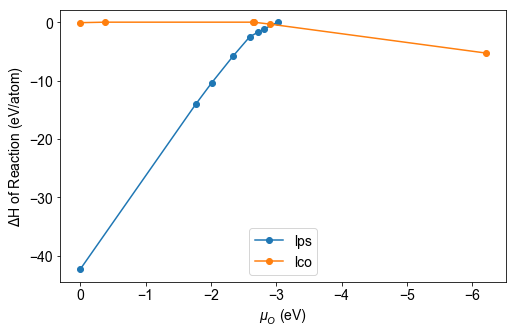

In [8]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

p1 = plt.plot((LPS[0]), (LPS[2]), 'o', ls='-', label= r'lps')
p2 = plt.plot((LCO[0]), (LCO[2]), 'o', ls='-', label= r'lco')
legend = ax.legend(loc='lower center')

# plt.xlim(-3.5, -2.5)
# plt.ylim(-5, 1)
ax.invert_xaxis()
#plt.title(r'$\Delta$H of Reaction of Li$_3$PS$_4$ with O$_2$ vs Chemical Potential')
plt.show()

In [1]:
LPS_200 = get_chempots_phases_enthalpies(['Li','P','S','O'],'Li3PS4','O', temp=500)
LCO_200 = get_chempots_phases_enthalpies(['Li','Co','O'],'LiCoO2','O', temp=500)

NameError: name 'get_chempots_phases_enthalpies' is not defined

In [10]:
pnds.options.display.float_format = '{:.3f}'.format
mu_shift_lps = '{:.3f}'.format(LPS_200[5][0])
mu_shift_lco = '{:.3f}'.format(LCO_200[5][0]) 
table1 = pnds.DataFrame({r'$\mu_O$* (eV)':LPS_200[5],
                      'Phase Equilibria':LPS_200[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ =' + mu_shift_lps:LPS_200[3],
                        r'$\Delta H_{rxn}$ at $\mu_O$*':LPS_200[2],
                        'Reaction':LPS_200[4]})
table2 = pnds.DataFrame({r'$\mu_O$* (eV)':LCO_200[5],
                      'Phase Equilibria':LCO_200[1],
                      r'$\Delta H_{rxn}$ at $\mu_O$ =' + mu_shift_lco:LCO_200[3],
                         r'$\Delta H_{rxn}$ at $\mu_O$*':LCO_200[2],
                        'Reaction':LCO_200[4]})
pnds.set_option('max_colwidth', 100)
cols1 = table1.columns.tolist()
cols2 = table2.columns.tolist()
neworder = [4, 3, 0, 2, 1]
cols1 = [cols1[i] for i in neworder]
cols2 = [cols2[i] for i in neworder]
table1 = table1[cols1]
table2 = table2[cols2]
display(table1)
display(table2)

,Reaction,Phase Equilibria,$\Delta H_{rxn}$ at $\mu_O$ =-0.270,$\mu_O$* (eV),$\Delta H_{rxn}$ at $\mu_O$*
0,8 O2 + Li3PS4 -> 3 SO3 + LiPO3 + Li2SO4,"[Li2SO4, SO3, LiPO3]",-39.024,-0.270,-39.024
1,6.5 O2 + Li3PS4 -> 3 SO2 + LiPO3 + Li2SO4,"[SO2, LiPO3, Li2SO4]",-34.519,-1.772,-15.000
2,6.25 O2 + Li3PS4 -> 3.5 SO2 + 0.5 Li4P2O7 + 0.5 Li2SO4,"[Li4P2O7, Li2SO4, SO2]",-33.449,-2.411,-6.693
3,6 O2 + Li3PS4 -> 4 SO2 + Li3PO4,"[SO2, Li3PO4]",-32.256,-2.657,-3.616
4,2.8 O2 + Li3PS4 -> 0.2 Li3PO4 + 1.2 Li2SO4 + 0.4 P2S7,"[P2S7, Li3PO4, Li2SO4]",-15.416,-2.901,-0.682
5,Li3PS4 -> Li3PS4,[Li3PS4],0.000,-3.023,0.000


,Reaction,Phase Equilibria,$\Delta H_{rxn}$ at $\mu_O$ =-0.270,$\mu_O$* (eV),$\Delta H_{rxn}$ at $\mu_O$*
0,0.1111 O2 + LiCoO2 -> 0.1111 Li7Co5O12 + 0.2222 Li(CoO2)2,"[Li(CoO2)2, Li7Co5O12]",-0.024,-0.270,-0.024
1,LiCoO2 -> LiCoO2,[LiCoO2],-0.000,-0.378,0.000
2,LiCoO2 -> 0.25 O2 + 0.8333 CoO + 0.1667 Li6CoO4,"[Li6CoO4, CoO]",1.187,-2.644,0.000
3,LiCoO2 -> 0.6667 O2 + 0.8333 Co + 0.1667 Li6CoO4,"[Li6CoO4, Co]",3.179,-2.660,-0.008
4,LiCoO2 -> 0.75 O2 + Co + 0.5 Li2O,"[Li2O, Co]",3.618,-2.903,-0.332
5,LiCoO2 -> O2 + Li + Co,"[Co, Li]",6.589,-6.213,-5.297


With temperature correction, the $\mu_O$ is nonzero even when T = 298 K. This is because the correction equation considers the gas entropy and the partial pressure, so there is a slight correction factor even at room temperature (previously, entropy was not considered at all).

IS X-AXIS POTENTIAL SHIFT CORRECT?

In [225]:
LPS_500 = get_chempots_phases_enthalpies(['Li','P','S','O'],'Li3PS4','O', temp=800)
LCO_500 = get_chempots_phases_enthalpies(['Li','Co','O'],'LiCoO2','O', temp=800)

{'SO3': -0.2389397321974141, 'SO2': -0.3185049777184428, 'CO2': 0, 'O2': -0.4050231119405361}
{'SO3': 0, 'SO2': 0, 'CO2': 0, 'O2': -0.4050231119405361}


In [12]:
mu_shift = '{:.3f}'.format(LPS_500[5][0])
mu_shift_lps = '{:.3f}'.format(LPS_500[5][0])
mu_shift_lco = '{:.3f}'.format(LCO_500[5][0]) 
table1 = pnds.DataFrame({r'$\mu_O$* (eV)':LPS_500[5],
                      'Phase Equilibria':LPS_500[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ =' + mu_shift_lps:LPS_500[3],
                         r'$\Delta H_{rxn}$ at $\mu_O$*':LPS_500[2],
                        'Reaction':LPS_500[4]})
table2 = pnds.DataFrame({r'$\mu_O$* (eV)':LCO_500[5],
                      'Phase Equilibria':LCO_500[1],
                      r'$\Delta H_{rxn}$ at $\mu_O$ =' + mu_shift_lco:LCO_500[3],
                         r'$\Delta H_{rxn}$ at $\mu_O$*':LCO_500[2],
                        'Reaction':LCO_500[4]})
pnds.set_option('max_colwidth', 100)

cols1 = table1.columns.tolist()
cols2 = table2.columns.tolist()
neworder = [4, 3, 0, 2, 1]
cols1 = [cols1[i] for i in neworder]
cols2 = [cols2[i] for i in neworder]
table1 = table1[cols1]
table2 = table2[cols2]

display(table1)
display(table2)

,Reaction,Phase Equilibria,$\Delta H_{rxn}$ at $\mu_O$ =-0.405,$\mu_O$* (eV),$\Delta H_{rxn}$ at $\mu_O$*
0,8 O2 + Li3PS4 -> 3 SO3 + LiPO3 + Li2SO4,"[SO3, LiPO3, Li2SO4]",-37.934,-0.405,-37.934
1,6.5 O2 + Li3PS4 -> 3 SO2 + LiPO3 + Li2SO4,"[SO2, LiPO3, Li2SO4]",-33.835,-1.771,-16.075
2,6.25 O2 + Li3PS4 -> 3.5 SO2 + 0.5 Li4P2O7 + 0.5 Li2SO4,"[Li4P2O7, Li2SO4, SO2]",-33.011,-2.053,-12.407
3,6 O2 + Li3PS4 -> 4 SO2 + Li3PO4,"[SO2, Li3PO4]",-32.064,-2.300,-9.330
4,Li3PS4 -> Li3PS4,[Li3PS4],0.000,-3.077,0.000


,Reaction,Phase Equilibria,$\Delta H_{rxn}$ at $\mu_O$ =-0.405,$\mu_O$* (eV),$\Delta H_{rxn}$ at $\mu_O$*
0,LiCoO2 -> LiCoO2,[LiCoO2],-0.000,-0.405,0.000
1,LiCoO2 -> 0.25 O2 + 0.8333 CoO + 0.1667 Li6CoO4,"[CoO, Li6CoO4]",1.120,-2.644,0.000
2,LiCoO2 -> 0.6667 O2 + 0.8333 Co + 0.1667 Li6CoO4,"[Co, Li6CoO4]",2.999,-2.660,-0.008
3,LiCoO2 -> 0.75 O2 + 0.5 Li2O + Co,"[Co, Li2O]",3.415,-2.903,-0.332
4,LiCoO2 -> O2 + Li + Co,"[Co, Li]",6.319,-6.213,-5.297


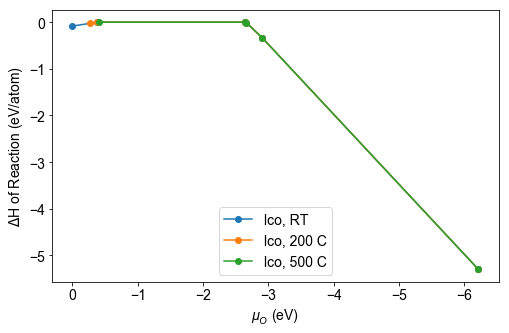

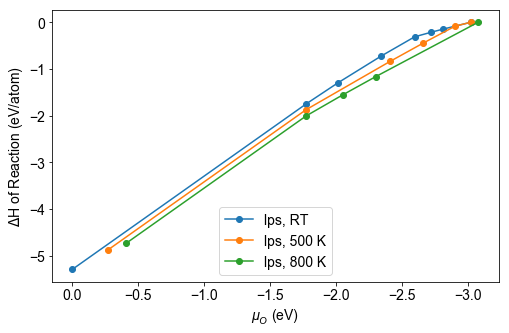

In [228]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

p2 = plt.plot((LCO[0]), (LCO[2]), 'o', ls='-', label= r'lco, RT')
p4 = plt.plot((LCO_200[5]), (LCO_200[2]), 'o', ls='-', label= r'lco, 200 C')
p6 = plt.plot((LCO_500[5]), (LCO_500[2]), 'o', ls='-', label= r'lco, 500 C')
legend = ax.legend(loc='lower center')

# plt.xlim(-3.5, -2.5)
# plt.ylim(-5, 1)
ax.invert_xaxis()
plt.show()

fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

lps_rt = pnds.Series(LPS[2])
lps_rt = lps_rt/8

lps_200 = pnds.Series(LPS_200[2])
lps_200 = lps_200/8

lps_500 = pnds.Series(LPS_500[2])
lps_500 = lps_500/8

p1 = plt.plot((LPS[0]), (lps_rt), 'o', ls='-', label= r'lps, RT')
p3 = plt.plot((LPS_200[5]), (lps_200), 'o', ls='-', label= r'lps, 500 K')
p5 = plt.plot((LPS_500[5]), (lps_500), 'o', ls='-', label= r'lps, 800 K')

legend = ax.legend(loc='lower center')
ax.invert_xaxis()
plt.show()

## LPS and LCO mix

In [17]:
LPS_LCO = get_mix_stability('Li3PS4', 'LiCoO2', ['Li','P','S','Co','O'], 'O', 0.5)

In [72]:
s = 'Li0.3125Co0.125P0.0625S0.25O0.25'
listylist = []
for r in LPS_LCO[4]:
    new = r.replace(s, 'LPS-LCO')
    listylist.append(new)

norm_H1 = pnds.Series(LPS_LCO[3])
norm_H1 = norm_H1*16
norm_H2 = pnds.Series(LPS_LCO[2])
norm_H2 = norm_H2*16
    
table4 = pnds.DataFrame({r'$\mu_O$* (eV)':LPS_LCO[5],
                      'Phase Equilibria':LPS_LCO[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':norm_H1,
                    r'$\Delta H_{rxn}$ at $\mu_O$*':norm_H2,
                        'Reaction':listylist})
display(table4)
pnds.set_option('max_colwidth', 400)

,$\Delta H_{rxn}$ at $\mu_O$ = 0.0,$\Delta H_{rxn}$ at $\mu_O$*,$\mu_O$* (eV),Phase Equilibria,Reaction
0,-45.929,-45.929,0.000,"[Li2SO4, CoPO4, CoSO4, Li2S2O7]",0.4844 O2 + LPS-LCO -> 0.03125 Li2S2O7 + 0.0625 CoSO4 + 0.0625 CoPO4 + 0.125 Li2SO4
1,-45.878,-42.744,-0.205,"[Li2SO4, CoPO4, CoSO4, Co(PO3)3]",0.4766 O2 + LPS-LCO -> 0.09375 CoSO4 + 0.01562 CoPO4 + 0.1562 Li2SO4 + 0.01562 Co(PO3)3
2,-45.866,-42.348,-0.231,"[LiCo(PO3)4, CoPO4, CoSO4, Li2SO4]",0.475 O2 + LPS-LCO -> 0.15 Li2SO4 + 0.0125 CoPO4 + 0.1 CoSO4 + 0.0125 LiCo(PO3)4
3,-45.786,-39.747,-0.403,"[Li2SO4, CoSO4, Co(PO3)2]",0.4687 O2 + LPS-LCO -> 0.09375 CoSO4 + 0.03125 Co(PO3)2 + 0.1562 Li2SO4
4,-33.167,-9.733,-2.403,"[Li2SO4, Co3(PO4)2, Co(PO3)2, CoS2]",0.3047 O2 + LPS-LCO -> 0.04687 CoS2 + 0.02344 Co3(PO4)2 + 0.1562 Li2SO4 + 0.007813 Co(PO3)2
5,-28.906,-9.426,-2.435,"[LiCoPO4, CoS2, Li2SO4]",0.25 O2 + LPS-LCO -> 0.125 Li2SO4 + 0.0625 CoS2 + 0.0625 LiCoPO4
6,-27.652,-8.846,-2.507,"[LiCoPO4, LiPO3, Co3S4, Li2SO4]",0.2344 O2 + LPS-LCO -> 0.125 Li2SO4 + 0.03125 LiPO3 + 0.03125 Co3S4 + 0.03125 LiCoPO4
7,-23.872,-8.753,-2.520,"[LiCoPO4, Li4P2O7, Co3S4, Li2SO4]",0.1875 O2 + LPS-LCO -> 0.1 Li2SO4 + 0.025 Li4P2O7 + 0.0375 Co3S4 + 0.0125 LiCoPO4
8,-21.311,-8.507,-2.561,"[Li2SO4, Li3PO4, Co3S4, Li4P2O7]",0.1563 O2 + LPS-LCO -> 0.04167 Co3S4 + 0.02083 Li3PO4 + 0.08333 Li2SO4 + 0.02083 Li4P2O7
9,-18.706,-8.286,-2.605,"[Li2SO4, Li3PO4, Co3S4, CoS2]",0.125 O2 + LPS-LCO -> 0.03125 Co3S4 + 0.0625 Li3PO4 + 0.0625 Li2SO4 + 0.03125 CoS2


In [18]:
LPS_LCO_200 = get_mix_stability('Li3PS4', 'LiCoO2', ['Li','P','S','Co','O'], 'O', 0.5, temp=500)

In [74]:
s = 'Li0.3125Co0.125P0.0625S0.25O0.25'
listylist = []
mu_shift = '{:.3f}'.format(LPS_LCO_200[5][0])

for r in LPS_LCO_200[4]:
    new = r.replace(s, 'LPS-LCO')
    listylist.append(new)

norm_H1 = pnds.Series(LPS_LCO_200[3])
norm_H1 = norm_H1*16
norm_H2 = pnds.Series(LPS_LCO_200[2])
norm_H2 = norm_H2*16

table5 = pnds.DataFrame({r'$\mu_O$* (eV)':LPS_LCO_200[5],
                      'Phase Equilibria':LPS_LCO_200[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = '+mu_shift:norm_H1,
                    r'$\Delta H_{rxn}$ at $\mu_O$*':norm_H2,
                        'Reaction':listylist})
display(table5)
pnds.set_option('max_colwidth', 400)

,$\Delta H_{rxn}$ at $\mu_O$ = -0.270,$\Delta H_{rxn}$ at $\mu_O$*,$\mu_O$* (eV),Phase Equilibria,Reaction
0,-41.762,-41.762,-0.270,"[CoSO4, Li2SO4, LiCo(PO3)4, CoPO4]",0.475 O2 + LPS-LCO -> 0.15 Li2SO4 + 0.0125 CoPO4 + 0.1 CoSO4 + 0.0125 LiCo(PO3)4
1,-41.736,-39.747,-0.403,"[CoSO4, Co(PO3)2, Li2SO4]",0.4687 O2 + LPS-LCO -> 0.1563 Li2SO4 + 0.03125 Co(PO3)2 + 0.09375 CoSO4
2,-39.978,-15.373,-2.027,"[Co3(PO4)2, SO2, Li2SO4, CoSO4]",0.4375 O2 + LPS-LCO -> 0.0625 SO2 + 0.03125 CoSO4 + 0.03125 Co3(PO4)2 + 0.1563 Li2SO4
3,-35.920,-9.897,-2.419,"[Co3(PO4)2, SO2, Co9S8, Li2SO4]",0.3785 O2 + LPS-LCO -> 0.06597 SO2 + 0.1562 Li2SO4 + 0.03125 Co3(PO4)2 + 0.003472 Co9S8
4,-31.806,-9.543,-2.448,"[LiCoPO4, SO2, Co9S8, Li2SO4]",0.3194 O2 + LPS-LCO -> 0.06944 SO2 + 0.125 Li2SO4 + 0.006944 Co9S8 + 0.0625 LiCoPO4
5,-29.825,-9.026,-2.498,"[LiCoPO4, SO2, Co3S4, Li2SO4]",0.2917 O2 + LPS-LCO -> 0.04167 SO2 + 0.125 Li2SO4 + 0.02083 Co3S4 + 0.0625 LiCoPO4
6,-22.252,-8.622,-2.542,"[LiCoPO4, Li2SO4, Co3S4, Li4P2O7]",0.1875 O2 + LPS-LCO -> 0.0375 Co3S4 + 0.025 Li4P2O7 + 0.1 Li2SO4 + 0.0125 LiCoPO4
7,-19.961,-8.507,-2.561,"[Li4P2O7, Li3PO4, Co3S4, Li2SO4]",0.1563 O2 + LPS-LCO -> 0.08333 Li2SO4 + 0.02083 Li4P2O7 + 0.04167 Co3S4 + 0.02083 Li3PO4
8,-17.626,-8.286,-2.605,"[CoS2, Li3PO4, Co3S4, Li2SO4]",0.125 O2 + LPS-LCO -> 0.0625 Li2SO4 + 0.03125 Co3S4 + 0.0625 Li3PO4 + 0.03125 CoS2
9,-6.441,-6.441,-3.066,"[CoS2, Li3PO4, Co3S4, Li2S]",LPS-LCO -> 0.0625 Li2S + 0.03125 Co3S4 + 0.0625 Li3PO4 + 0.03125 CoS2


In [19]:
LPS_LCO_500 = get_mix_stability('Li3PS4', 'LiCoO2', ['Li','P','S','Co','O'], 'O', 0.5, temp=800)

In [77]:
s = 'Li0.3125Co0.125P0.0625S0.25O0.25'
mu_shift = '{:.3f}'.format(LPS_LCO_500[5][0])

listylist = []
for r in LPS_LCO_500[4]:
    new = r.replace(s, 'LPS-LCO')
    listylist.append(new)

mu_shift = '{:.3f}'.format(LPS_LCO_500[5][0])

norm_H1 = pnds.Series(LPS_LCO_500[3])
norm_H1 = norm_H1*16
norm_H2 = pnds.Series(LPS_LCO_500[2])
norm_H2 = norm_H2*16

table6 = pnds.DataFrame({r'$\mu_O$* (eV)':LPS_LCO_500[5],
                      'Phase Equilibria':LPS_LCO_500[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = '+mu_shift:norm_H1,
                    r'$\Delta H_{rxn}$ at $\mu_O$*':norm_H2,
                        'Reaction':listylist})
display(table6)
pnds.set_option('max_colwidth', 400)

,$\Delta H_{rxn}$ at $\mu_O$ = -0.405,$\Delta H_{rxn}$ at $\mu_O$*,$\mu_O$* (eV),Phase Equilibria,Reaction
0,-39.844,-39.844,-0.405,"[CoSO4, CoPO4, SO3, Li2SO4]",0.4844 O2 + LPS-LCO -> 0.03125 SO3 + 0.1563 Li2SO4 + 0.0625 CoPO4 + 0.0625 CoSO4
1,-39.811,-38.819,-0.471,"[CoSO4, Li2SO4, SO3, Co3(PO4)2]",0.4688 O2 + LPS-LCO -> 0.1562 Li2SO4 + 0.0625 SO3 + 0.03125 Co3(PO4)2 + 0.03125 CoSO4
2,-38.445,-19.318,-1.771,"[SO2, CoSO4, Li2SO4, Co3(PO4)2]",0.4375 O2 + LPS-LCO -> 0.0625 SO2 + 0.1563 Li2SO4 + 0.03125 Co3(PO4)2 + 0.03125 CoSO4
3,-37.449,-10.554,-2.397,"[SO2, Co3(PO4)2, CoO, Li2SO4]",0.4219 O2 + LPS-LCO -> 0.09375 SO2 + 0.1563 Li2SO4 + 0.03125 Co3(PO4)2 + 0.03125 CoO
4,-34.661,-10.354,-2.412,"[SO2, Co3(PO4)2, Li2SO4, Co9S8]",0.3785 O2 + LPS-LCO -> 0.06597 SO2 + 0.003472 Co9S8 + 0.03125 Co3(PO4)2 + 0.1562 Li2SO4
5,-30.822,-10.048,-2.437,"[SO2, Co9S8, LiCoPO4, Li2SO4]",0.3194 O2 + LPS-LCO -> 0.06944 SO2 + 0.125 Li2SO4 + 0.006944 Co9S8 + 0.0625 LiCoPO4
6,-22.694,-8.828,-2.557,"[SO2, Co9S8, Li2SO4, Li3PO4]",0.2014 O2 + LPS-LCO -> 0.07639 SO2 + 0.0625 Li2SO4 + 0.0625 Li3PO4 + 0.01389 Co9S8
7,-18.655,-8.052,-2.677,"[SO2, Li3PO4, Co3S4, Li2SO4]",0.1458 O2 + LPS-LCO -> 0.02083 SO2 + 0.0625 Li2SO4 + 0.0625 Li3PO4 + 0.04167 Co3S4
8,-17.086,-7.675,-2.758,"[CoS2, Li3PO4, Co3S4, Li2SO4]",0.125 O2 + LPS-LCO -> 0.0625 Li2SO4 + 0.03125 Co3S4 + 0.0625 Li3PO4 + 0.03125 CoS2
9,-6.441,-6.441,-3.066,"[CoS2, Li3PO4, Co3S4, Li2S]",LPS-LCO -> 0.0625 Li2S + 0.03125 Co3S4 + 0.0625 Li3PO4 + 0.03125 CoS2


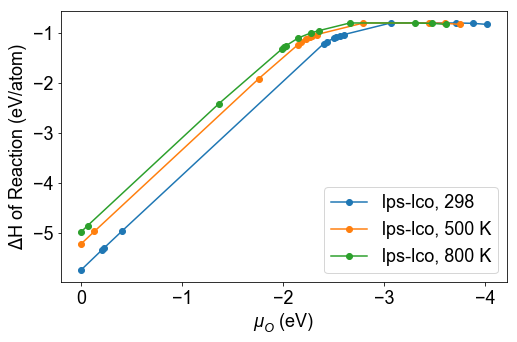

In [21]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

norm_H1 = pnds.Series(LPS_LCO[2])
norm_H1 = norm_H1*2

norm_H2 = pnds.Series(LPS_LCO_200[2])
norm_H2 = norm_H2*2

norm_H3 = pnds.Series(LPS_LCO_500[2])
norm_H3 = norm_H3*2

p1 = plt.plot((LPS_LCO[0]), (norm_H1), 'o', ls='-', label= r'lps-lco, 298')
p2 = plt.plot((LPS_LCO_200[0]), (norm_H2), 'o', ls='-', label= r'lps-lco, 500 K')
p3 = plt.plot((LPS_LCO_500[0]), (norm_H3), 'o', ls='-', label= r'lps-lco, 800 K')

legend = ax.legend(loc='lower right')
# plt.xlim(-2.9, -2)
# plt.ylim(-2, -0.9)
#plt.gca().set_ylim(top=0)
ax.invert_xaxis()
#plt.title(r'$\Delta$H of Reaction of Li$_3$PS$_4$ with O$_2$ vs Chemical Potential')
plt.show()

## LATP and LLZO High-Temperature Calculations

In [7]:
LATP = get_chempots_phases_enthalpies(['Li','Al','Ti','P','O'],'Li13Al3Ti17P30O120','O')

{'SO3': 0, 'SO2': 0, 'CO2': 0, 'O2': 0}


In [160]:
LTP = get_chempots_phases_enthalpies(['Li','Ti','P','O'],'LiTi2P3O12','O')

{'SO3': 0, 'SO2': 0, 'CO2': 0, 'O2': 0}


In [8]:
LLZO = get_chempots_phases_enthalpies(['Li','La','Zr','O'],'Li7La3Zr2O12','O')

{'SO3': 0, 'SO2': 0, 'CO2': 0, 'O2': 0}


In [12]:
pnds.options.display.float_format = '{:.3f}'.format

norm_H1 = pnds.Series(LATP[2])
norm_H1 = norm_H1/183

norm_H2 = pnds.Series(LLZO[2])
norm_H2 = norm_H2/24

table6 = pnds.DataFrame({r'$\mu_O$* (eV)':LATP[0],
                      'Phase Equilibria':LATP[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':LATP[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':norm_H1,
                        'Reaction':LATP[4]})
table7 = pnds.DataFrame({r'$\mu_O$* (eV)':LLZO[0],
                      'Phase Equilibria':LLZO[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':LLZO[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':norm_H2,
                        'Reaction':LLZO[4]})

pnds.set_option('max_colwidth', 100)

cols = table6.columns.tolist()
neworder = [4, 3, 0, 2, 1]
cols = [cols[i] for i in neworder]
table6 = table6[cols]
table7 = table7[cols]

display(table6)
display(table7)

,Reaction,Phase Equilibria,$\Delta H_{rxn}$ at $\mu_O$ = 0.0,$\mu_O$* (eV),$\Delta H_{rxn}$ at $\mu_O$*
0,Li13Ti17Al3(PO4)30 -> Li13Ti17Al3(PO4)30,[Li13Ti17Al3(PO4)30],0.000,0.000,0.000
1,Li13Ti17Al3(PO4)30 -> 7.5 O2 + 4 LiTi2(PO4)3 + 9 LiTiPO5 + 3 AlPO4 + 6 P,"[P, LiTi2(PO4)3, LiTiPO5, AlPO4]",58.645,-3.910,-0.000
2,Li13Ti17Al3(PO4)30 -> 17.5 O2 + 13 LiTiPO5 + 3 AlPO4 + 4 TiO2 + 14 P,"[P, AlPO4, LiTiPO5, TiO2]",137.051,-3.920,-0.001
3,Li13Ti17Al3(PO4)30 -> 28.33 O2 + 4.333 Li3PO4 + 3 AlPO4 + 17 TiO2 + 22.67 P,"[P, AlPO4, Li3PO4, TiO2]",222.455,-3.942,-0.005
4,Li13Ti17Al3(PO4)30 -> 39.67 O2 + 4.333 Li3PO4 + 3 AlPO4 + 11.33 TiP2 + 5.667 TiO2,"[AlPO4, Li3PO4, TiO2, TiP2]",314.205,-4.048,-0.038
5,Li13Ti17Al3(PO4)30 -> 45.27 O2 + 0.6 LiAl5O8 + 4.133 Li3PO4 + 12.93 TiP2 + 4.067 TiO2,"[TiP2, Li3PO4, LiAl5O8, TiO2]",359.802,-4.071,-0.048
6,Li13Ti17Al3(PO4)30 -> 49.33 O2 + 0.6 LiAl5O8 + 4.133 Li3PO4 + 8.867 TiP2 + 8.133 TiP,"[TiP2, Li3PO4, LiAl5O8, TiP]",393.440,-4.136,-0.080
7,Li13Ti17Al3(PO4)30 -> 50.33 O2 + 3 LiAlO2 + 3.333 Li3PO4 + 7.333 TiP + 9.667 TiP2,"[TiP, LiAlO2, Li3PO4, TiP2]",402.207,-4.384,-0.213
8,Li13Ti17Al3(PO4)30 -> 53.56 O2 + 3 LiAlO2 + 1.611 Li3P7 + 1.722 Li3PO4 + 17 TiP,"[TiP, LiAlO2, Li3P7, Li3PO4]",432.869,-4.758,-0.419
9,Li13Ti17Al3(PO4)30 -> 57 O2 + 3 LiAlO2 + 0.75 Li3P7 + 7.75 LiP + 17 TiP,"[TiP, LiAlO2, Li3P7, LiP]",465.963,-4.804,-0.446


,Reaction,Phase Equilibria,$\Delta H_{rxn}$ at $\mu_O$ = 0.0,$\mu_O$* (eV),$\Delta H_{rxn}$ at $\mu_O$*
0,1.75 O2 + Li7La3Zr2O12 -> La2Zr2O7 + 3.5 Li2O2 + 0.5 La2O3,"[La2Zr2O7, Li2O2, La2O3]",-0.745,0.000,-0.024
1,0.25 O2 + Li7La3Zr2O12 -> 0.5 Li2O2 + 1.5 La2O3 + Li6Zr2O7,"[La2O3, Li6Zr2O7, Li2O2]",-0.368,-0.126,-0.005
2,Li7La3Zr2O12 -> Li6Zr2O7 + 0.5 Li2O + 1.5 La2O3,"[Li2O, Li6Zr2O7, La2O3]",-0.175,-0.387,0.000
3,Li7La3Zr2O12 -> 1.667 O2 + 0.6667 Zr3O + 1.5 La2O3 + 3.5 Li2O,"[Zr3O, La2O3, Li2O]",20.215,-6.117,-0.000
4,Li7La3Zr2O12 -> 2 O2 + 2 Zr + 1.5 La2O3 + 3.5 Li2O,"[Li2O, La2O3, Zr]",24.351,-6.204,-0.012
5,Li7La3Zr2O12 -> 3.75 O2 + 2 Zr + 1.5 La2O3 + 7 Li,"[Zr, La2O3, Li]",46.095,-6.213,-0.014
6,Li7La3Zr2O12 -> 6 O2 + 2 Zr + 3 La + 7 Li,"[Zr, La, Li]",75.305,-6.491,-0.101


No gas phase formation here in the phase equilibria of these SSE. Now that y-axis shift is not enforced, the $\Delta H$ for the 0 chemical potential and the shifted chemical potential are quite different.

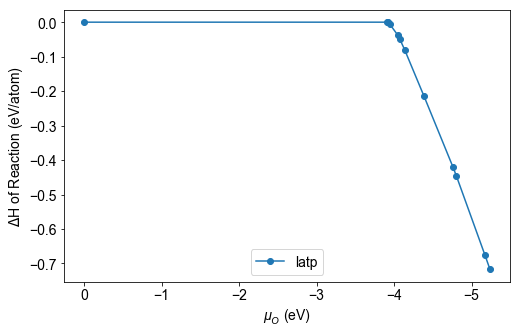

In [221]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

norm_H = pnds.Series(LATP[2])
norm_H = norm_H*2
norm_H2 = pnds.Series(LATP_200[2])
norm_H2 = norm_H2*2

# p1 = plt.plot((LTP[0]), (norm_H2), 'o-', label= r'ltp')
p2 = plt.plot(LATP[0], norm_H, 'o', ls='-', label= r'latp')
legend = ax.legend(loc='lower center')

ax.invert_xaxis()
plt.show()

In [82]:
LATP_200 = get_chempots_phases_enthalpies(['Li','Al','Ti','P','O'],'Li13Al3Ti17P30O120','O', temp=500)
LATP_500 = get_chempots_phases_enthalpies(['Li','Al','Ti','P','O'],'Li13Al3Ti17P30O120','O', temp=800)

{'SO3': 0, 'SO2': 0, 'CO2': 0, 'O2': -0.2699917116035555}
{'SO3': 0, 'SO2': 0, 'CO2': 0, 'O2': -0.4050231119405361}


In [83]:
mu_shift = '{:.3f}'.format(LATP_200[5][0])
pnds.options.display.float_format = '{:.3f}'.format

pnds.options.display.float_format = '{:.3f}'.format
table8 = pnds.DataFrame({r'$\mu_O$* (eV)':LATP_200[5],
                      'Phase Equilibria':LATP_200[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = '+mu_shift: LATP_200[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':LATP_200[2],
                        'Reaction':LATP_200[4]})
pnds.set_option('max_colwidth', 100)

cols = table8.columns.tolist()
neworder = [4, 3, 0, 2, 1]
cols = [cols[i] for i in neworder]
table8 = table8[cols]

display(table8)

,Reaction,Phase Equilibria,$\Delta H_{rxn}$ at $\mu_O$ = -0.270,$\mu_O$* (eV),$\Delta H_{rxn}$ at $\mu_O$*
0,Li13Ti17Al3(PO4)30 -> Li13Ti17Al3(PO4)30,[Li13Ti17Al3(PO4)30],0.000,-0.270,0.000
1,Li13Ti17Al3(PO4)30 -> 7.5 O2 + 9 LiTiPO5 + 4 LiTi2(PO4)3 + 3 AlPO4 + 6 P,"[P, LiTiPO5, AlPO4, LiTi2(PO4)3]",54.595,-3.910,-0.000
2,Li13Ti17Al3(PO4)30 -> 17.5 O2 + 13 LiTiPO5 + 3 AlPO4 + 4 TiO2 + 14 P,"[P, LiTiPO5, AlPO4, TiO2]",127.602,-3.920,-0.160
3,Li13Ti17Al3(PO4)30 -> 28.33 O2 + 4.333 Li3PO4 + 3 AlPO4 + 17 TiO2 + 22.67 P,"[P, Li3PO4, AlPO4, TiO2]",207.155,-3.942,-0.908
4,Li13Ti17Al3(PO4)30 -> 39.67 O2 + 4.333 Li3PO4 + 3 AlPO4 + 11.33 TiP2 + 5.667 TiO2,"[TiP2, AlPO4, TiO2, Li3PO4]",292.786,-4.048,-6.921
5,Li13Ti17Al3(PO4)30 -> 45.27 O2 + 0.6 LiAl5O8 + 4.133 Li3PO4 + 12.93 TiP2 + 4.067 TiO2,"[TiP2, LiAl5O8, TiO2, Li3PO4]",335.359,-4.071,-8.770
6,Li13Ti17Al3(PO4)30 -> 49.33 O2 + 0.6 LiAl5O8 + 4.133 Li3PO4 + 8.867 TiP2 + 8.133 TiP,"[TiP2, TiP, LiAl5O8, Li3PO4]",366.801,-4.136,-14.629
7,Li13Ti17Al3(PO4)30 -> 50.33 O2 + 3 LiAlO2 + 3.333 Li3PO4 + 7.333 TiP + 9.667 TiP2,"[LiAlO2, TiP, Li3PO4, TiP2]",375.028,-4.384,-39.066
8,Li13Ti17Al3(PO4)30 -> 53.56 O2 + 3 LiAlO2 + 1.611 Li3P7 + 1.722 Li3PO4 + 17 TiP,"[LiAlO2, TiP, Li3P7, Li3PO4]",403.950,-4.758,-76.757
9,Li13Ti17Al3(PO4)30 -> 57 O2 + 3 LiAlO2 + 0.75 Li3P7 + 7.75 LiP + 17 TiP,"[LiAlO2, TiP, Li3P7, LiP]",435.183,-4.804,-81.682


In [84]:
mu_shift = '{:.3f}'.format(LATP_500[5][0])
pnds.options.display.float_format = '{:.3f}'.format

pnds.options.display.float_format = '{:.3f}'.format
table8 = pnds.DataFrame({r'$\mu_O$* (eV)':LATP_500[5],
                      'Phase Equilibria':LATP_500[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = '+mu_shift: LATP_500[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':LATP_500[2],
                        'Reaction':LATP_500[4]})
pnds.set_option('max_colwidth', 100)

cols = table8.columns.tolist()
neworder = [4, 3, 0, 2, 1]
cols = [cols[i] for i in neworder]
table8 = table8[cols]

display(table8)

,Reaction,Phase Equilibria,$\Delta H_{rxn}$ at $\mu_O$ = -0.405,$\mu_O$* (eV),$\Delta H_{rxn}$ at $\mu_O$*
0,Li13Ti17Al3(PO4)30 -> Li13Ti17Al3(PO4)30,[Li13Ti17Al3(PO4)30],0.000,-0.405,0.000
1,Li13Ti17Al3(PO4)30 -> 7.5 O2 + 4 LiTi2(PO4)3 + 9 LiTiPO5 + 3 AlPO4 + 6 P,"[LiTi2(PO4)3, P, LiTiPO5, AlPO4]",52.569,-3.910,-0.000
2,Li13Ti17Al3(PO4)30 -> 17.5 O2 + 13 LiTiPO5 + 3 AlPO4 + 4 TiO2 + 14 P,"[AlPO4, P, LiTiPO5, TiO2]",122.876,-3.920,-0.160
3,Li13Ti17Al3(PO4)30 -> 28.33 O2 + 4.333 Li3PO4 + 3 AlPO4 + 17 TiO2 + 22.67 P,"[AlPO4, P, Li3PO4, TiO2]",199.504,-3.942,-0.908
4,Li13Ti17Al3(PO4)30 -> 39.67 O2 + 4.333 Li3PO4 + 3 AlPO4 + 11.33 TiP2 + 5.667 TiO2,"[AlPO4, Li3PO4, TiO2, TiP2]",282.073,-4.048,-6.921
5,Li13Ti17Al3(PO4)30 -> 45.27 O2 + 0.6 LiAl5O8 + 4.133 Li3PO4 + 12.93 TiP2 + 4.067 TiO2,"[TiP2, LiAl5O8, Li3PO4, TiO2]",323.134,-4.071,-8.770
6,Li13Ti17Al3(PO4)30 -> 49.33 O2 + 0.6 LiAl5O8 + 4.133 Li3PO4 + 8.867 TiP2 + 8.133 TiP,"[TiP2, LiAl5O8, Li3PO4, TiP]",353.478,-4.136,-14.629
7,Li13Ti17Al3(PO4)30 -> 50.33 O2 + 3 LiAlO2 + 3.333 Li3PO4 + 7.333 TiP + 9.667 TiP2,"[LiAlO2, Li3PO4, TiP, TiP2]",361.435,-4.384,-39.066
8,Li13Ti17Al3(PO4)30 -> 53.56 O2 + 3 LiAlO2 + 1.611 Li3P7 + 1.722 Li3PO4 + 17 TiP,"[LiAlO2, Li3P7, TiP, Li3PO4]",389.487,-4.758,-76.757
9,Li13Ti17Al3(PO4)30 -> 57 O2 + 3 LiAlO2 + 7.75 LiP + 0.75 Li3P7 + 17 TiP,"[LiAlO2, LiP, TiP, Li3P7]",419.790,-4.804,-81.682


In [1]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

p1 = plt.plot((LATP[0]), (LATP[2]), 'o-', label= r'latp, 300 K')
p2 = plt.plot((LATP_200[5]), (LATP_200[2]), 'o', ls='-', label= r'latp, 500 K')
p3 = plt.plot((LATP_500[5]), (LATP_500[2]), 'o', ls='-', label= r'latp, 800 K')
legend = ax.legend(loc='lower center')

ax.invert_xaxis()
plt.show()

NameError: name 'plt' is not defined

In [87]:
LLZO_200 = get_chempots_phases_enthalpies(['Li','La','Zr','O'],'Li7La3Zr2O12','O',temp=500)
LLZO_500 = get_chempots_phases_enthalpies(['Li','La','Zr','O'],'Li7La3Zr2O12','O',temp=800)

{'SO3': 0, 'SO2': 0, 'CO2': 0, 'O2': -0.2699917116035555}
{'SO3': 0, 'SO2': 0, 'CO2': 0, 'O2': -0.4050231119405361}


In [88]:
mu_shift = '{:.3f}'.format(LLZO_200[5][0])
pnds.options.display.float_format = '{:.3f}'.format

pnds.options.display.float_format = '{:.3f}'.format
table8 = pnds.DataFrame({r'$\mu_O$* (eV)':LLZO_200[5],
                      'Phase Equilibria':LLZO_200[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = '+mu_shift: LLZO_200[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':LLZO_200[2],
                        'Reaction':LLZO_200[4]})
pnds.set_option('max_colwidth', 100)

cols = table8.columns.tolist()
neworder = [4, 3, 0, 2, 1]
cols = [cols[i] for i in neworder]
table8 = table8[cols]

display(table8)

,Reaction,Phase Equilibria,$\Delta H_{rxn}$ at $\mu_O$ = -0.270,$\mu_O$* (eV),$\Delta H_{rxn}$ at $\mu_O$*
0,0.25 O2 + Li7La3Zr2O12 -> 0.5 Li2O2 + 1.5 La2O3 + Li6Zr2O7,"[Li6Zr2O7, La2O3, Li2O2]",-0.233,-0.270,-0.059
1,Li7La3Zr2O12 -> 0.5 Li2O + 1.5 La2O3 + Li6Zr2O7,"[Li6Zr2O7, La2O3, Li2O]",-0.175,-0.387,0.000
2,Li7La3Zr2O12 -> 1.667 O2 + 0.6667 Zr3O + 1.5 La2O3 + 3.5 Li2O,"[Zr3O, La2O3, Li2O]",19.315,-6.117,-0.000
3,Li7La3Zr2O12 -> 2 O2 + 2 Zr + 1.5 La2O3 + 3.5 Li2O,"[Li2O, La2O3, Zr]",23.271,-6.204,-0.290
4,Li7La3Zr2O12 -> 3.75 O2 + 2 Zr + 1.5 La2O3 + 7 Li,"[Zr, La2O3, Li]",44.071,-6.213,-0.326
5,Li7La3Zr2O12 -> 6 O2 + 2 Zr + 3 La + 7 Li,"[La, Zr, Li]",72.065,-6.491,-2.413


In [89]:
mu_shift = '{:.3f}'.format(LLZO_500[5][0])
pnds.options.display.float_format = '{:.3f}'.format

table8 = pnds.DataFrame({r'$\mu_O$* (eV)':LLZO_500[5],
                      'Phase Equilibria':LLZO_500[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = '+mu_shift: LLZO_500[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':LLZO_500[2],
                        'Reaction':LLZO_500[4]})
pnds.set_option('max_colwidth', 100)

cols = table8.columns.tolist()
neworder = [4, 3, 0, 2, 1]
cols = [cols[i] for i in neworder]
table8 = table8[cols]

display(table8)

,Reaction,Phase Equilibria,$\Delta H_{rxn}$ at $\mu_O$ = -0.405,$\mu_O$* (eV),$\Delta H_{rxn}$ at $\mu_O$*
0,Li7La3Zr2O12 -> 0.5 Li2O + 1.5 La2O3 + Li6Zr2O7,"[La2O3, Li6Zr2O7, Li2O]",-0.175,-0.405,0.000
1,Li7La3Zr2O12 -> 1.667 O2 + 0.6667 Zr3O + 1.5 La2O3 + 3.5 Li2O,"[La2O3, Zr3O, Li2O]",18.865,-6.117,0.000
2,Li7La3Zr2O12 -> 2 O2 + 2 Zr + 1.5 La2O3 + 3.5 Li2O,"[Zr, Li2O, La2O3]",22.731,-6.204,-0.290
3,Li7La3Zr2O12 -> 3.75 O2 + 2 Zr + 1.5 La2O3 + 7 Li,"[Zr, La2O3, Li]",43.058,-6.213,-0.326
4,Li7La3Zr2O12 -> 6 O2 + 2 Zr + 3 La + 7 Li,"[Zr, Li, La]",70.445,-6.491,-2.413


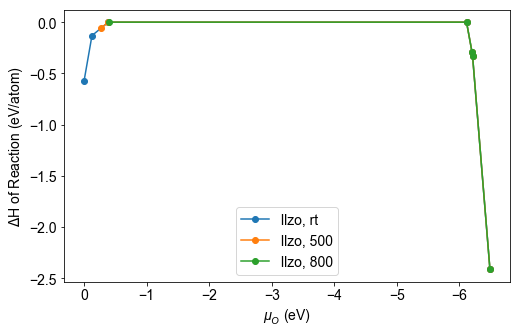

In [90]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

p1 = plt.plot((LLZO[0]), (LLZO[2]), 'o-', label= r'llzo, rt')
p2 = plt.plot((LLZO_200[5]), (LLZO_200[2]), 'o-', label= r'llzo, 500')
p3 = plt.plot((LLZO_500[5]), (LLZO_500[2]), 'o-', label= r'llzo, 800')
legend = ax.legend(loc='lower center')

gca.

ax.invert_xaxis()
plt.show()

## LLZO and LATP with LCO, pseudo-binary

In [248]:
LATP_LCO = get_mix_stability('Li13Al3Ti17P30O120', 'LiCoO2', ['Li','Al','P','Ti','Co','O'], 'O', 0.5)

In [249]:
LATP_LCO_200 = get_mix_stability('Li13Al3Ti17P30O120', 'LiCoO2', ['Li','Al','P','Ti','Co','O'], 'O', 0.5, temp=500)
LATP_LCO_500 = get_mix_stability('Li13Al3Ti17P30O120', 'LiCoO2', ['Li','Al','P','Ti','Co','O'], 'O', 0.5, temp=800)

In [233]:
s = 'Li0.16051913Ti0.04644809Al0.00819672Co0.125P0.08196721O0.57786885'
shortname = []
for r in LATP_LCO[4]:
    new = r.replace(s, 'LATP-LCO')
    shortname.append(new)

norm_H1 = pnds.Series(LATP_LCO[3])
norm_H1 = norm_H1*183
norm_H2 = pnds.Series(LATP_LCO[2])
norm_H2 = norm_H2*183
    
table = pnds.DataFrame({r'$\mu_O$* (eV)':LATP_LCO[5],
                      'Phase Equilibria':LATP_LCO[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':norm_H1,
                    r'$\Delta H_{rxn}$ at $\mu_O$*':norm_H2})
reactions = pnds.DataFrame({'Reaction':shortname})
pnds.set_option('max_colwidth', 400)

display(table)
display(reactions)

,$\Delta H_{rxn}$ at $\mu_O$ = 0.0,$\Delta H_{rxn}$ at $\mu_O$*,$\mu_O$* (eV),Phase Equilibria
0,-9.132,-9.132,0.000,"[LiTiPO5, Li3PO4, Li(CoO2)2, AlPO4, CoO2]"
1,-8.992,-8.703,-0.051,"[LiTiPO5, Li3PO4, Li(CoO2)2, AlPO4, LiTi2(PO4)3]"
2,-7.948,-7.704,-0.225,"[LiTiPO5, Li3PO4, Li(CoO2)2, AlPO4, Co3O4]"
3,-6.689,-7.670,-0.257,"[LiTiPO5, Li3PO4, TiO2, AlPO4, Co3O4]"
4,-5.486,-9.163,-0.649,"[AlPO4, Co3O4, Li3PO4, LiCoPO4, TiO2]"
5,-4.267,-12.393,-1.219,"[Al(CoO2)2, Co3O4, Li3PO4, LiCoPO4, TiO2]"
6,-2.184,-14.069,-1.470,"[Al(CoO2)2, Co3O4, Li3PO4, LiCoPO4, Ti2CoO5]"
7,0.553,-17.803,-1.932,"[Al(CoO2)2, Co3O4, Li3PO4, TiCoO3, LiCoPO4]"
8,2.857,-17.878,-1.940,"[Al(CoO2)2, LiCoPO4, Li3PO4, TiCoO3, CoO]"
9,4.341,-18.284,-1.978,"[CoO, LiCoPO4, Li3PO4, TiCoO3, Al2CoO4]"


,Reaction
0,LATP-LCO + 0.02322 O2 -> 0.04645 LiTiPO5 + 0.02732 Li3PO4 + 0.06079 CoO2 + 0.008197 AlPO4 + 0.0321 Li(CoO2)2
1,LATP-LCO + 0.01563 O2 -> 0.03125 LiTiPO5 + 0.007599 LiTi2(PO4)3 + 0.01972 Li3PO4 + 0.008197 AlPO4 + 0.0625 Li(CoO2)2
2,LATP-LCO + 0.00296 O2 -> 0.04645 LiTiPO5 + 0.02732 Li3PO4 + 0.02026 Co3O4 + 0.008197 AlPO4 + 0.0321 Li(CoO2)2
3,LATP-LCO -> 0.01042 O2 + 0.0304 LiTiPO5 + 0.04337 Li3PO4 + 0.04167 Co3O4 + 0.008197 AlPO4 + 0.01605 TiO2
4,LATP-LCO -> 0.01548 O2 + 0.04337 Li3PO4 + 0.03153 Co3O4 + 0.008197 AlPO4 + 0.0304 LiCoPO4 + 0.04645 TiO2
5,LATP-LCO -> 0.01821 O2 + 0.008197 Al(CoO2)2 + 0.03928 Li3PO4 + 0.02197 Co3O4 + 0.04269 LiCoPO4 + 0.04645 TiO2
6,LATP-LCO -> 0.02209 O2 + 0.008197 Al(CoO2)2 + 0.02322 Ti2CoO5 + 0.03928 Li3PO4 + 0.01423 Co3O4 + 0.04269 LiCoPO4
7,LATP-LCO -> 0.02596 O2 + 0.008197 Al(CoO2)2 + 0.04645 TiCoO3 + 0.03928 Li3PO4 + 0.006489 Co3O4 + 0.04269 LiCoPO4
8,LATP-LCO -> 0.0292 O2 + 0.008197 Al(CoO2)2 + 0.04645 TiCoO3 + 0.03928 Li3PO4 + 0.01947 CoO + 0.04269 LiCoPO4
9,LATP-LCO -> 0.03125 O2 + 0.004098 Al2CoO4 + 0.04645 TiCoO3 + 0.03928 Li3PO4 + 0.03176 CoO + 0.04269 LiCoPO4


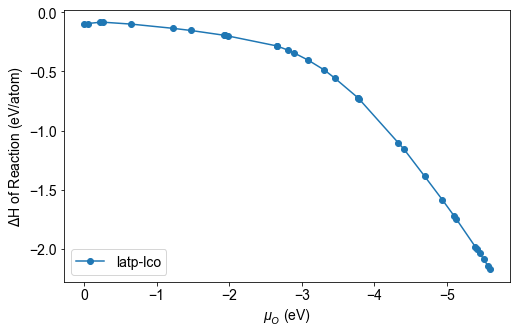

In [251]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

norm_H1 = pnds.Series(LATP_LCO[2])
norm_H1 = norm_H1*2

norm_H2 = pnds.Series(LATP_LCO_200[2])
norm_H2 = norm_H2*366

norm_H3 = pnds.Series(LATP_LCO_500[2])
norm_H3 = norm_H3*366

p1 = plt.plot((LATP_LCO[0]), norm_H1, 'o-', label= r'latp-lco')
#p2 = plt.plot((LATP_LCO[0]), LATP_LCO[2], 'o-', label= r'latp-lco')
# p2 = plt.plot((LATP_LCO_500[5]), (norm_H3), 'o-', label= r'latp-lco, 800 K')

legend = ax.legend(loc='lower left')
ax.invert_xaxis()
plt.show()

In [155]:
LTP_LCO = get_mix_stability('LiTi2P3O12', 'LiCoO2', ['Li','Ti','P','Co','O'], 'O', 0.5)

In [164]:
s = 'Li0.15277778Ti0.05555556Co0.125P0.08333333O0.58333333'
shortname = []
for r in LTP_LCO[4]:
    new = r.replace(s, 'LTP-LCO')
    shortname.append(new)

norm_H1 = pnds.Series(LTP_LCO[3])
norm_H1 = norm_H1*36
norm_H2 = pnds.Series(LTP_LCO[2])
norm_H2 = norm_H2*36
    
table = pnds.DataFrame({r'$\mu_O$* (eV)':LTP_LCO[5],
                      'Phase Equilibria':LTP_LCO[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':norm_H1,
                    r'$\Delta H_{rxn}$ at $\mu_O$*':norm_H2,
                        'Reaction':shortname})
display(table)

,$\Delta H_{rxn}$ at $\mu_O$ = 0.0,$\Delta H_{rxn}$ at $\mu_O$*,$\mu_O$* (eV),Phase Equilibria,Reaction
0,-1.813,-1.813,0.000,"[Li(CoO2)2, Li3PO4, CoO2, LiTiPO5]",0.02778 O2 + LTP-LCO -> 0.05556 LiTiPO5 + 0.02778 Li3PO4 + 0.09722 CoO2 + 0.01389 Li(CoO2)2
1,-1.769,-1.712,-0.051,"[Li(CoO2)2, Li3PO4, LiTi2(PO4)3, LiTiPO5]",0.01562 O2 + LTP-LCO -> 0.01215 LiTi2(PO4)3 + 0.03125 LiTiPO5 + 0.01563 Li3PO4 + 0.0625 Li(CoO2)2
2,-1.441,-1.516,-0.225,"[Li(CoO2)2, Li3PO4, Co3O4, LiTiPO5]",LTP-LCO -> 0.00463 O2 + 0.05556 LiTiPO5 + 0.02778 Li3PO4 + 0.03241 Co3O4 + 0.01389 Li(CoO2)2
3,-1.333,-1.526,-0.257,"[LiTiPO5, TiO2, Co3O4, Li3PO4]",LTP-LCO -> 0.01042 O2 + 0.04861 LiTiPO5 + 0.03472 Li3PO4 + 0.04167 Co3O4 + 0.006944 TiO2
4,-0.955,-1.820,-0.649,"[LiCoPO4, TiO2, Co3O4, Li3PO4]",LTP-LCO -> 0.01852 O2 + 0.03472 Li3PO4 + 0.02546 Co3O4 + 0.04861 LiCoPO4 + 0.05556 TiO2
5,-0.465,-2.915,-1.470,"[Ti2CoO5, Li3PO4, Co3O4, LiCoPO4]",LTP-LCO -> 0.02315 O2 + 0.02778 Ti2CoO5 + 0.03472 Li3PO4 + 0.0162 Co3O4 + 0.04861 LiCoPO4
6,0.179,-3.685,-1.932,"[LiCoPO4, Li3PO4, TiCoO3, Co3O4]",LTP-LCO -> 0.02778 O2 + 0.05556 TiCoO3 + 0.03472 Li3PO4 + 0.006944 Co3O4 + 0.04861 LiCoPO4
7,0.664,-3.701,-1.940,"[LiCoPO4, Li3PO4, TiCoO3, CoO]",LTP-LCO -> 0.03125 O2 + 0.05556 TiCoO3 + 0.03472 Li3PO4 + 0.02083 CoO + 0.04861 LiCoPO4
8,2.659,-5.321,-2.660,"[LiCoPO4, Li3PO4, TiCoO3, Co]",LTP-LCO -> 0.04167 O2 + 0.05556 TiCoO3 + 0.03472 Li3PO4 + 0.02083 Co + 0.04861 LiCoPO4
9,5.322,-5.329,-2.663,"[Ti2CoO5, Li3PO4, Co, LiCoPO4]",LTP-LCO -> 0.05556 O2 + 0.02778 Ti2CoO5 + 0.03472 Li3PO4 + 0.04861 Co + 0.04861 LiCoPO4


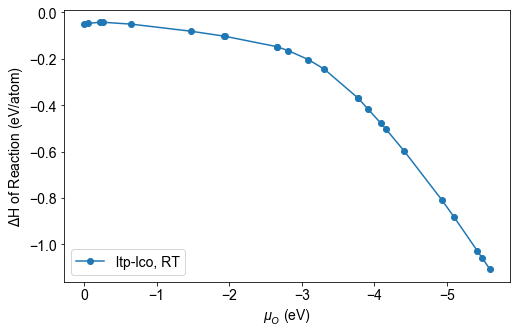

In [253]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

norm_H1 = pnds.Series(LTP_LCO[2])
norm_H1 = norm_H1*36

p1 = plt.plot((LTP_LCO[0]), LTP_LCO[2], 'o-', label= r'ltp-lco, RT')

# plt.xlim(-1,0)
# plt.ylim(-5,0)

legend = ax.legend(loc='lower left')
ax.invert_xaxis()
plt.show()

In [104]:
LLZO_LCO = get_mix_stability('Li7La3Zr2O12', 'LiCoO2', ['Li','La','Zr','Co','O'], 'O', 0.5)
LLZO_LCO_200 = get_mix_stability('Li7La3Zr2O12', 'LiCoO2', ['Li','La','Zr','Co','O'], 'O', 0.5, temp=500)
LLZO_LCO_500 = get_mix_stability('Li7La3Zr2O12', 'LiCoO2',['Li','La','Zr','Co','O'], 'O', 0.5, temp=800)

In [105]:
s = 'Li0.27083333La0.0625Zr0.04166667Co0.125O0.5'
shortname = []
for r in LLZO_LCO[4]:
    new = r.replace(s, 'LLZO-LCO')
    shortname.append(new)

norm_H1 = pnds.Series(LLZO_LCO[3])
norm_H1 = norm_H1*48
norm_H2 = pnds.Series(LLZO_LCO[2])
norm_H2 = norm_H2*48
    
table = pnds.DataFrame({r'$\mu_O$* (eV)':LLZO_LCO[5],
                      'Phase Equilibria':LLZO_LCO[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':norm_H1,
                    r'$\Delta H_{rxn}$ at $\mu_O$*':norm_H2,
                        'Reaction':shortname})
display(table)

,$\Delta H_{rxn}$ at $\mu_O$ = 0.0,$\Delta H_{rxn}$ at $\mu_O$*,$\mu_O$* (eV),Phase Equilibria,Reaction
0,-1.738,-1.738,0.000,"[La2O3, Li2O2, La2Zr2O7, Li7Co5O12]",0.03646 O2 + LLZO-LCO -> 0.01042 La2O3 + 0.04792 Li2O2 + 0.025 Li7Co5O12 + 0.02083 La2Zr2O7
1,-1.449,-1.298,-0.126,"[La2O3, La2Zr2O7, Li7Co5O12, Li6Zr2O7]",0.0125 O2 + LLZO-LCO -> 0.02639 La2O3 + 0.01597 Li6Zr2O7 + 0.025 Li7Co5O12 + 0.004861 La2Zr2O7
2,-0.782,-0.305,-0.953,"[La2O3, LiCoO2, Li7Co5O12, Li6Zr2O7]",0.005208 O2 + LLZO-LCO -> 0.03125 La2O3 + 0.02083 Li6Zr2O7 + 0.01042 Li7Co5O12 + 0.07292 LiCoO2
3,-0.207,-0.207,-1.151,"[La2O3, Li5CoO4, LiCoO2, Li6Zr2O7]",LLZO-LCO -> 0.03125 La2O3 + 0.02083 Li6Zr2O7 + 0.1198 LiCoO2 + 0.005208 Li5CoO4
4,0.049,-0.207,-2.560,"[La2O3, Li6CoO4, LiCoO2, Li6Zr2O7]",LLZO-LCO -> 0.001042 O2 + 0.03125 La2O3 + 0.02083 Li6Zr2O7 + 0.1208 LiCoO2 + 0.004167 Li6CoO4
5,7.717,-0.215,-2.644,"[La2O3, CoO, Li6Zr2O7, Li6CoO4]",LLZO-LCO -> 0.03125 O2 + 0.03125 La2O3 + 0.1007 CoO + 0.02431 Li6CoO4 + 0.02083 Li6Zr2O7
6,20.574,-0.263,-2.660,"[La2O3, Co, Li6Zr2O7, Li6CoO4]",LLZO-LCO -> 0.0816 O2 + 0.03125 La2O3 + 0.1007 Co + 0.02431 Li6CoO4 + 0.02083 Li6Zr2O7
7,23.961,-2.165,-2.903,"[La2O3, Co, Li6Zr2O7, Li2O]",LLZO-LCO -> 0.09375 O2 + 0.07292 Li2O + 0.03125 La2O3 + 0.125 Co + 0.02083 Li6Zr2O7
8,41.497,-26.454,-5.602,"[La2O3, Zr6Co23, Li6Zr2O7, Li2O]",LLZO-LCO -> 0.1264 O2 + 0.1218 Li2O + 0.03125 La2O3 + 0.005435 Zr6Co23 + 0.004529 Li6Zr2O7
9,46.490,-28.151,-5.742,"[La2O3, Zr6Co23, Li2O, ZrCo2]",LLZO-LCO -> 0.1354 O2 + 0.1354 Li2O + 0.03125 La2O3 + 0.01894 ZrCo2 + 0.003788 Zr6Co23


In [106]:
s = 'Li0.27083333La0.0625Zr0.04166667Co0.125O0.5'
shortname = []
for r in LLZO_LCO_500[4]:
    new = r.replace(s, 'LLZO-LCO')
    shortname.append(new)

norm_H1 = pnds.Series(LLZO_LCO_500[3])
norm_H1 = norm_H1*48
norm_H2 = pnds.Series(LLZO_LCO_500[2])
norm_H2 = norm_H2*48
    
table = pnds.DataFrame({r'$\mu_O$* (eV)':LLZO_LCO_500[5],
                      'Phase Equilibria':LLZO_LCO_500[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':norm_H1,
                    r'$\Delta H_{rxn}$ at $\mu_O$*':norm_H2,
                        'Reaction':shortname})
display(table)
pnds.set_option('max_colwidth', 400)

,$\Delta H_{rxn}$ at $\mu_O$ = 0.0,$\Delta H_{rxn}$ at $\mu_O$*,$\mu_O$* (eV),Phase Equilibria,Reaction
0,-0.963,-0.963,-0.405,"[Li7Co5O12, La2Zr2O7, La2O3, Li6Zr2O7]",0.0125 O2 + LLZO-LCO -> 0.004861 La2Zr2O7 + 0.01597 Li6Zr2O7 + 0.025 Li7Co5O12 + 0.02639 La2O3
1,-0.579,-0.305,-0.953,"[LiCoO2, Li7Co5O12, La2O3, Li6Zr2O7]",0.005208 O2 + LLZO-LCO -> 0.03125 La2O3 + 0.02083 Li6Zr2O7 + 0.01042 Li7Co5O12 + 0.07292 LiCoO2
2,-0.207,-0.207,-1.151,"[Li6Zr2O7, Li5CoO4, La2O3, LiCoO2]",LLZO-LCO -> 0.03125 La2O3 + 0.02083 Li6Zr2O7 + 0.1198 LiCoO2 + 0.005208 Li5CoO4
3,0.009,-0.207,-2.560,"[Li6Zr2O7, Li6CoO4, La2O3, LiCoO2]",LLZO-LCO -> 0.001042 O2 + 0.03125 La2O3 + 0.02083 Li6Zr2O7 + 0.1208 LiCoO2 + 0.004167 Li6CoO4
4,6.502,-0.215,-2.644,"[Li6Zr2O7, CoO, Li6CoO4, La2O3]",LLZO-LCO -> 0.03125 O2 + 0.1007 CoO + 0.02083 Li6Zr2O7 + 0.02431 Li6CoO4 + 0.03125 La2O3
5,17.402,-0.263,-2.660,"[Li6Zr2O7, Co, Li6CoO4, La2O3]",LLZO-LCO -> 0.0816 O2 + 0.1007 Co + 0.03125 La2O3 + 0.02083 Li6Zr2O7 + 0.02431 Li6CoO4
6,20.316,-2.165,-2.903,"[Li6Zr2O7, Co, La2O3, Li2O]",LLZO-LCO -> 0.09375 O2 + 0.125 Co + 0.03125 La2O3 + 0.02083 Li6Zr2O7 + 0.07292 Li2O
7,36.584,-26.454,-5.602,"[Li6Zr2O7, Zr6Co23, La2O3, Li2O]",LLZO-LCO -> 0.1264 O2 + 0.1218 Li2O + 0.03125 La2O3 + 0.005435 Zr6Co23 + 0.004529 Li6Zr2O7
8,41.224,-28.151,-5.742,"[ZrCo2, Zr6Co23, La2O3, Li2O]",LLZO-LCO -> 0.1354 O2 + 0.1354 Li2O + 0.03125 La2O3 + 0.003788 Zr6Co23 + 0.01894 ZrCo2
9,78.975,-34.277,-6.213,"[Li, ZrCo2, Zr6Co23, La2O3]",LLZO-LCO -> 0.2031 O2 + 0.003788 Zr6Co23 + 0.03125 La2O3 + 0.01894 ZrCo2 + 0.2708 Li


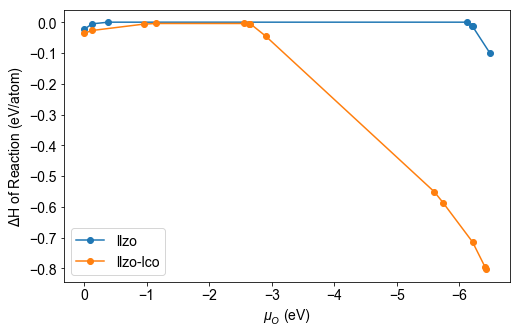

In [202]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

norm_H1 = pnds.Series(LLZO[2])
norm_H1 = norm_H1/24

norm_H2 = pnds.Series(LLZO_LCO[2])
norm_H2 = norm_H2

norm_H3 = pnds.Series(LLZO_LCO_500[2])
norm_H3 = norm_H3*36

p1 = plt.plot(LLZO[0], norm_H1, 'o-', label= r'llzo')
p2 = plt.plot(LLZO_LCO[0], LLZO_L, 'o-', label= r'llzo-lco')
# p3 = plt.plot(LLZO_LCO_500[5], norm_H3, 'o-', label= r'800 K')

# plt.xlim(-3.25, 0.1)
# plt.ylim(-2.6, 0.5)
legend = ax.legend(loc='lower left')
ax.invert_xaxis()

plt.show()

## Anode Studies

In [111]:
li = get_chempots_phases_enthalpies(['Li','O'],'Li','O')
c = get_chempots_phases_enthalpies(['C','O'],'C','O')
si = get_chempots_phases_enthalpies(['Si','O'],'Si','O')

{'SO3': 0, 'SO2': 0, 'CO2': 0, 'O2': 0}
{'SO3': 0, 'SO2': 0, 'CO2': 0, 'O2': 0}
{'SO3': 0, 'SO2': 0, 'CO2': 0, 'O2': 0}


In [42]:
table1 = pnds.DataFrame({r'$\mu_O$* (eV)':li[0],
                      'Phase Equilibria':li[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':li[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':li[2],
                        'Reaction':li[4]})
table2 = pnds.DataFrame({r'$\mu_O$* (eV)':c[0],
                      'Phase Equilibria':c[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':c[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':c[2],
                        'Reaction':c[4]})
table3 = pnds.DataFrame({r'$\mu_O$* (eV)':si[0],
                      'Phase Equilibria':si[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':si[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':si[2],
                        'Reaction':si[4]})

pnds.set_option('max_colwidth', 100)

cols = table1.columns.tolist()
neworder = [4, 3, 0, 2, 1]
cols = [cols[i] for i in neworder]
table1 = table1[cols]
table2 = table2[cols]
table3 = table3[cols]

display(table1)
display(table2)
display(table3)

,Reaction,Phase Equilibria,$\Delta H_{rxn}$ at $\mu_O$ = 0.0,$\mu_O$* (eV),$\Delta H_{rxn}$ at $\mu_O$*
0,0.5 O2 + Li -> 0.5 Li2O2,[Li2O2],-3.300,0.000,-3.300
1,0.25 O2 + Li -> 0.5 Li2O,[Li2O],-3.106,-0.387,-2.913
2,Li -> Li,[Li],0.000,-6.213,0.000


,Reaction,Phase Equilibria,$\Delta H_{rxn}$ at $\mu_O$ = 0.0,$\mu_O$* (eV),$\Delta H_{rxn}$ at $\mu_O$*
0,O2 + C -> CO2,[CO2],-5.366,0.000,-5.366
1,C -> C,[C],0.000,-2.683,0.000


,Reaction,Phase Equilibria,$\Delta H_{rxn}$ at $\mu_O$ = 0.0,$\mu_O$* (eV),$\Delta H_{rxn}$ at $\mu_O$*
0,O2 + Si -> SiO2,[SiO2],-9.854,0.000,-9.854
1,Si -> Si,[Si],0.000,-4.927,0.000


In [136]:
c = get_chempots_phases_enthalpies(['C','O'],'C','O')
c_200 = get_chempots_phases_enthalpies(['C','O'],'C','O',temp=500)
c_500 = get_chempots_phases_enthalpies(['C','O'],'C','O',temp=800)

{'SO3': 0, 'SO2': 0, 'CO2': 0, 'O2': 0}
{'SO3': 0, 'SO2': 0, 'CO2': -0.047594611916142046, 'O2': -0.2699917116035555}
{'SO3': 0, 'SO2': 0, 'CO2': -0.07533496344098548, 'O2': -0.4050231119405361}


In [137]:
mu_1 = '{:.3f}'.format(c_200[5][0])
mu_2 = '{:.3f}'.format(c_500[5][0])

pnds.options.display.float_format = '{:.3f}'.format
table1 = pnds.DataFrame({r'$\mu_O$* (eV)':c[0],
                      'Phase Equilibria':c[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':c[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':c[2],
                        'Reaction':c[4]})
table2 = pnds.DataFrame({r'$\mu_O$* (eV)':c_200[5],
                      'Phase Equilibria':c_200[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = ' + mu_1:c_200[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':c_200[2],
                        'Reaction':c_200[4]})
table3 = pnds.DataFrame({r'$\mu_O$* (eV)':c_500[5],
                      'Phase Equilibria':c_500[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = '+mu_2:c_500[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':c_500[2],
                        'Reaction':c_500[4]})

pnds.set_option('max_colwidth', 100)

cols1 = table1.columns.tolist()
cols2 = table2.columns.tolist()
cols3 = table3.columns.tolist()

neworder = [4, 3, 0, 2, 1]
cols1 = [cols1[i] for i in neworder]
cols2 = [cols2[i] for i in neworder]
cols3 = [cols3[i] for i in neworder]

table1 = table1[cols1]
table2 = table2[cols2]
table3 = table3[cols3]

display(table1)
display(table2)
display(table3)

,Reaction,Phase Equilibria,$\Delta H_{rxn}$ at $\mu_O$ = 0.0,$\mu_O$* (eV),$\Delta H_{rxn}$ at $\mu_O$*
0,O2 + C -> CO2,[CO2],-5.366,0.000,-5.366
1,C -> C,[C],0.000,-2.683,0.000


,Reaction,Phase Equilibria,$\Delta H_{rxn}$ at $\mu_O$ = -0.270,$\mu_O$* (eV),$\Delta H_{rxn}$ at $\mu_O$*
0,O2 + C -> CO2,[CO2],-4.968,-0.270,-4.968
1,C -> C,[C],0.000,-2.754,0.000


,Reaction,Phase Equilibria,$\Delta H_{rxn}$ at $\mu_O$ = -0.405,$\mu_O$* (eV),$\Delta H_{rxn}$ at $\mu_O$*
0,O2 + C -> CO2,[CO2],-4.782,-0.405,-4.782
1,C -> C,[C],0.000,-2.796,0.000


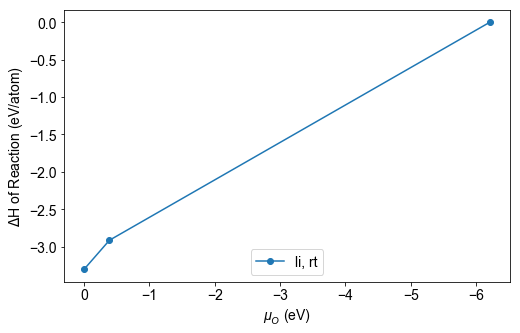

In [208]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

p1 = plt.plot((li[0]), (li[2]), 'o-', label= r'li, rt')
# p2 = plt.plot((c_200[5]), (c_200[2]), 'o-', label= r'c, 200')
# p3 = plt.plot((c_500[5]), (c_500[2]), 'o-', label= r'c, 500')

legend = ax.legend(loc='lower center')

ax.invert_xaxis()
plt.show()

## Anode LTP Mix

In [127]:
latp_s = 'Li13Al3Ti17P30O120'
shrtnm = 'Li0.03551913Ti0.04644809Al0.00819672P0.08196721C0.5O0.32786885'

In [145]:
C_LTP = get_mix_stability('LiTi2P3O12', 'C', ['C','Al','Li','Ti','P','O'], 'O', 0.5)
C_LTP_200 = get_mix_stability('LiTi2P3O12', 'C', ['C','Al','Li','Ti','P','O'], 'O', 0.5, temp=500)
C_LTP_500 = get_mix_stability('LiTi2P3O12', 'C', ['C','Al','Li','Ti','P','O'], 'O', 0.5, temp=800)

In [147]:
s = 'Li0.02777778Ti0.05555556P0.08333333C0.5O0.33333333'
shortname = []
for r in C_LTP[4]:
    new = r.replace(s, 'C-LTP')
    shortname.append(new)

norm_H1 = pnds.Series(C_LTP[3])
norm_H1 = norm_H1*2
norm_H2 = pnds.Series(C_LTP[2])
norm_H2 = norm_H2*2
    
table = pnds.DataFrame({r'$\mu_O$* (eV)':C_LTP[5],
                      'Phase Equilibria':C_LTP[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':norm_H1,
                    r'$\Delta H_{rxn}$ at $\mu_O$*':norm_H2,
                       'Reaction':shortname})
display(table)

table2 = pnds.DataFrame({'Reaction':shortname})
display(table2)
pnds.set_option('max_colwidth', 400)

,$\Delta H_{rxn}$ at $\mu_O$ = 0.0,$\Delta H_{rxn}$ at $\mu_O$*,$\mu_O$* (eV),Phase Equilibria,Reaction
0,-5.366,-5.366,0.000,"[CO2, LiTi2(PO4)3]",0.5 O2 + C-LTP -> 0.02778 LiTi2(PO4)3 + 0.5 CO2
1,-0.000,-0.000,-2.683,"[C, LiTi2(PO4)3]",C-LTP -> 0.02778 LiTi2(PO4)3 + 0.5 C
2,1.089,-0.000,-3.920,"[P, C, LiTiPO5, TiO2]",C-LTP -> 0.06944 O2 + 0.02778 LiTiPO5 + 0.02778 TiO2 + 0.5 C + 0.05556 P
3,1.454,-0.006,-3.942,"[P, C, Li3PO4, TiO2]",C-LTP -> 0.09259 O2 + 0.009259 Li3PO4 + 0.05556 TiO2 + 0.5 C + 0.07407 P
4,2.054,-0.045,-4.048,"[TiP2, C, Li3PO4, TiO2]",C-LTP -> 0.1296 O2 + 0.009259 Li3PO4 + 0.01852 TiO2 + 0.03704 TiP2 + 0.5 C
5,2.360,-0.091,-4.136,"[TiP2, C, Li3PO4, TiP]",C-LTP -> 0.1481 O2 + 0.009259 Li3PO4 + 0.01852 TiP2 + 0.5 C + 0.03704 TiP
6,2.477,-0.460,-4.758,"[C, TiP, Li3PO4, Li3P7]",C-LTP -> 0.1543 O2 + 0.006173 Li3PO4 + 0.003086 Li3P7 + 0.05556 TiP + 0.5 C
7,2.715,-0.488,-4.804,"[C, LiP, TiP]",C-LTP -> 0.1667 O2 + 0.02778 LiP + 0.05556 TiP + 0.5 C


,Reaction
0,0.5 O2 + C-LTP -> 0.02778 LiTi2(PO4)3 + 0.5 CO2
1,C-LTP -> 0.02778 LiTi2(PO4)3 + 0.5 C
2,C-LTP -> 0.06944 O2 + 0.02778 LiTiPO5 + 0.02778 TiO2 + 0.5 C + 0.05556 P
3,C-LTP -> 0.09259 O2 + 0.009259 Li3PO4 + 0.05556 TiO2 + 0.5 C + 0.07407 P
4,C-LTP -> 0.1296 O2 + 0.009259 Li3PO4 + 0.01852 TiO2 + 0.03704 TiP2 + 0.5 C
5,C-LTP -> 0.1481 O2 + 0.009259 Li3PO4 + 0.01852 TiP2 + 0.5 C + 0.03704 TiP
6,C-LTP -> 0.1543 O2 + 0.006173 Li3PO4 + 0.003086 Li3P7 + 0.05556 TiP + 0.5 C
7,C-LTP -> 0.1667 O2 + 0.02778 LiP + 0.05556 TiP + 0.5 C


In [149]:
s = 'Li0.02777778Ti0.05555556P0.08333333C0.5O0.33333333'
shortname = []
for r in C_LTP_200[4]:
    new = r.replace(s, 'C-LTP')
    shortname.append(new)

mu_1 = '{:.3f}'.format(C_LTP_200[5][0])
norm_H1 = pnds.Series(C_LTP_200[3])
norm_H1 = norm_H1*2
norm_H2 = pnds.Series(C_LTP_200[2])
norm_H2 = norm_H2*2
    
table = pnds.DataFrame({r'$\mu_O$* (eV)':C_LTP_200[5],
                      'Phase Equilibria':C_LTP_200[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = '+mu_1:norm_H1,
                    r'$\Delta H_{rxn}$ at $\mu_O$*':norm_H2,
                        'Reaction':shortname})
display(table)
pnds.set_option('max_colwidth', 400)

,$\Delta H_{rxn}$ at $\mu_O$ = -0.270,$\Delta H_{rxn}$ at $\mu_O$*,$\mu_O$* (eV),Phase Equilibria,Reaction
0,-4.968,-4.968,-0.270,"[LiTi2(PO4)3, CO2]",0.5 O2 + C-LTP -> 0.02778 LiTi2(PO4)3 + 0.5 CO2
1,-0.000,-0.000,-2.754,"[LiTi2(PO4)3, C]",C-LTP -> 0.02778 LiTi2(PO4)3 + 0.5 C
2,1.014,0.000,-3.920,"[TiO2, C, LiTiPO5, P]",C-LTP -> 0.06944 O2 + 0.02778 LiTiPO5 + 0.5 C + 0.02778 TiO2 + 0.05556 P
3,1.354,-0.006,-3.942,"[Li3PO4, C, P, TiO2]",C-LTP -> 0.09259 O2 + 0.009259 Li3PO4 + 0.05556 TiO2 + 0.5 C + 0.07407 P
4,1.914,-0.045,-4.048,"[Li3PO4, TiP2, C, TiO2]",C-LTP -> 0.1296 O2 + 0.009259 Li3PO4 + 0.01852 TiO2 + 0.03704 TiP2 + 0.5 C
5,2.200,-0.091,-4.136,"[Li3PO4, C, TiP, TiP2]",C-LTP -> 0.1481 O2 + 0.009259 Li3PO4 + 0.03704 TiP + 0.5 C + 0.01852 TiP2
6,2.311,-0.460,-4.758,"[Li3PO4, C, Li3P7, TiP]",C-LTP -> 0.1543 O2 + 0.006173 Li3PO4 + 0.003086 Li3P7 + 0.5 C + 0.05556 TiP
7,2.535,-0.488,-4.804,"[C, LiP, TiP]",C-LTP -> 0.1667 O2 + 0.02778 LiP + 0.05556 TiP + 0.5 C


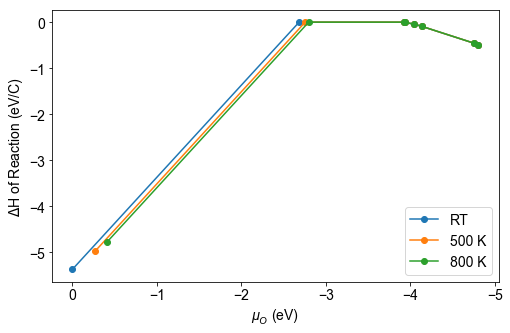

In [151]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/C)')
ax.set_xlabel(r'$\mu_O$ (eV)')

norm_H1 = pnds.Series(C_LTP[2])
norm_H1 = norm_H1*2

norm_H2 = pnds.Series(C_LTP_200[2])
norm_H2 = norm_H2*2

norm_H3 = pnds.Series(C_LTP_500[2])
norm_H3 = norm_H3*2

p1 = plt.plot(C_LTP[0], norm_H1, 'o-', label= r'RT')
p2 = plt.plot(C_LTP_200[5], norm_H2, 'o-', label= r'500 K')
p3 = plt.plot(C_LTP_500[5], norm_H3, 'o-', label= r'800 K')

# plt.xlim(-3.25, 0.1)
# plt.ylim(-2.6, 0.5)
legend = ax.legend(loc='lower right')
ax.invert_xaxis()

plt.show()

In [119]:
Li_LTP = get_mix_stability('mp-135', 'mp-18640', ['Li','Ti','P','O'], 'O', 0.5)
Li_LTP_200 = get_mix_stability(, 'mp-18640', ['Li','Ti','P','O'], 'O', 0.5, temp=500)
Li_LTP_500 = get_mix_stability('mp-135', 'mp-18640', ['Li','Ti','P','O'], 'O', 0.5, temp=800)

In [51]:
s = 'Li0.52777778Ti0.05555556P0.08333333O0.33333333'
shortname = []
for r in Li_LTP[4]:
    new = r.replace(s, 'Li-LTP')
    shortname.append(new)

norm_H1 = pnds.Series(Li_LTP[3])
norm_H1 = norm_H1*(3.6)
norm_H2 = pnds.Series(Li_LTP[2])
norm_H2 = norm_H2*(3.6)
    
table = pnds.DataFrame({r'$\mu_O$* (eV)':Li_LTP[5],
                      'Phase Equilibria':Li_LTP[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':norm_H1,
                    r'$\Delta H_{rxn}$ at $\mu_O$*':norm_H2,
                        'Reaction':shortname})
display(table)
pnds.set_option('max_colwidth', 400)

,$\Delta H_{rxn}$ at $\mu_O$ = 0.0,$\Delta H_{rxn}$ at $\mu_O$*,$\mu_O$* (eV),Phase Equilibria,Reaction
0,-6.750,-6.750,0.000,"[Li3PO4, Li2TiO3, Li2O2]",Li-LTP + 0.1667 O2 -> 0.05556 Li2TiO3 + 0.08333 Li3PO4 + 0.08333 Li2O2
1,-6.729,-6.629,-0.101,"[Li3PO4, Li4TiO4, Li2O2]",Li-LTP + 0.1389 O2 -> 0.05556 Li4TiO4 + 0.08333 Li3PO4 + 0.02778 Li2O2
2,-6.691,-6.342,-0.387,"[Li3PO4, Li2O, Li4TiO4]",Li-LTP + 0.125 O2 -> 0.05556 Li4TiO4 + 0.08333 Li3PO4 + 0.02778 Li2O
3,-0.887,-2.338,-4.837,"[Li4TiO4, Li2O, Li3P]",Li-LTP -> 0.04167 O2 + 0.05556 Li4TiO4 + 0.08333 Li3P + 0.02778 Li2O
4,0.550,-2.611,-5.749,"[Ti2P, Li2O, Li3P]",Li-LTP -> 0.07639 O2 + 0.05556 Li3P + 0.1806 Li2O + 0.02778 Ti2P
5,0.858,-2.838,-6.161,"[Ti3P, Li2O, Li3P]",Li-LTP -> 0.08333 O2 + 0.06481 Li3P + 0.1667 Li2O + 0.01852 Ti3P
6,4.586,-2.869,-6.213,"[Li3P, Li, Ti3P]",Li-LTP -> 0.1667 O2 + 0.06481 Li3P + 0.3333 Li + 0.01852 Ti3P


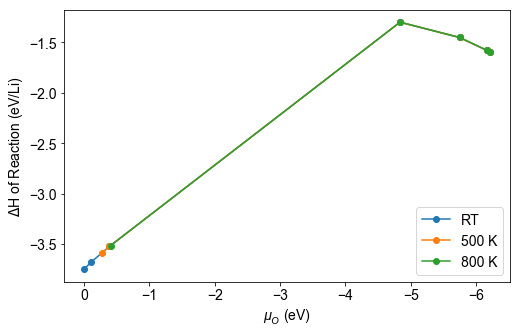

In [153]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/Li)')
ax.set_xlabel(r'$\mu_O$ (eV)')

norm_H1 = pnds.Series(Li_LTP[2])
norm_H1 = norm_H1*2

norm_H2 = pnds.Series(Li_LTP_200[2])
norm_H2 = norm_H2*2

norm_H3 = pnds.Series(Li_LTP_500[2])
norm_H3 = norm_H3*2

p1 = plt.plot(Li_LTP[0], norm_H1, 'o-', label= r'RT')
p2 = plt.plot(Li_LTP_200[5], norm_H2, 'o-', label= r'500 K')
p3 = plt.plot(Li_LTP_500[5], norm_H3, 'o-', label= r'800 K')

# plt.xlim(-3.25, 0.1)
# plt.ylim(-2.6, 0.5)
legend = ax.legend(loc='lower right')
ax.invert_xaxis()

plt.show()

In [120]:
si_LTP = get_mix_stability('mp-149', 'mp-18640', ['Si','Li','Ti','P','O'], 'O', 0.5)
si_LTP_200 = get_mix_stability('mp-149', 'mp-18640', ['Si','Li','Ti','P','O'], 'O', 0.5, temp=500)
si_LTP_500 = get_mix_stability('mp-149', 'mp-18640', ['Si','Li','Ti','P','O'], 'O', 0.5, temp=800)

In [121]:
s = 'Li0.02777778Ti0.05555556Si0.5P0.08333333O0.33333333'
shortname = []
for r in si_LTP[4]:
    new = r.replace(s, 'Si-LTP')
    shortname.append(new)

norm_H1 = pnds.Series(si_LTP[3])
norm_H1 = norm_H1*2
norm_H2 = pnds.Series(si_LTP[2])
norm_H2 = norm_H2*2
    
table = pnds.DataFrame({r'$\mu_O$* (eV)':si_LTP[5],
                      'Phase Equilibria':si_LTP[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':norm_H1,
                    r'$\Delta H_{rxn}$ at $\mu_O$*':norm_H2,
                        'Reaction':shortname})
display(table)
pnds.set_option('max_colwidth', 400)

,$\Delta H_{rxn}$ at $\mu_O$ = 0.0,$\Delta H_{rxn}$ at $\mu_O$*,$\mu_O$* (eV),Phase Equilibria,Reaction
0,-9.854,-9.854,0.000,"[LiTi2(PO4)3, SiO2]",0.5 O2 + Si-LTP -> 0.02778 LiTi2(PO4)3 + 0.5 SiO2
1,-8.765,-2.013,-3.920,"[P, LiTiPO5, SiO2, TiO2]",0.4306 O2 + Si-LTP -> 0.02778 LiTiPO5 + 0.02778 TiO2 + 0.5 SiO2 + 0.05556 P
2,-8.400,-1.976,-3.942,"[P, TiO2, SiO2, Li3PO4]",0.4074 O2 + Si-LTP -> 0.009259 Li3PO4 + 0.5 SiO2 + 0.05556 TiO2 + 0.07407 P
3,-7.800,-1.804,-4.048,"[TiP2, SiO2, Li3PO4, TiO2]",0.3704 O2 + Si-LTP -> 0.009259 Li3PO4 + 0.01852 TiO2 + 0.03704 TiP2 + 0.5 SiO2
4,-7.494,-1.673,-4.136,"[TiP2, SiO2, TiP, Li3PO4]",0.3519 O2 + Si-LTP -> 0.009259 Li3PO4 + 0.01852 TiP2 + 0.5 SiO2 + 0.03704 TiP
5,-7.296,-1.471,-4.280,"[TiP2, Li2Si2O5, TiP, SiO2]",0.3403 O2 + Si-LTP -> 0.01389 Li2Si2O5 + 0.02778 TiP2 + 0.4722 SiO2 + 0.02778 TiP
6,-6.761,-0.743,-4.815,"[TiP, SiO2, SiP, Li2Si2O5]",0.3125 O2 + Si-LTP -> 0.01389 Li2Si2O5 + 0.05556 TiP + 0.4444 SiO2 + 0.02778 SiP
7,1.998,-0.602,-4.927,"[TiP, Si, SiP, Li2Si2O5]",Si-LTP -> 0.1319 O2 + 0.01389 Li2Si2O5 + 0.05556 TiP + 0.4444 Si + 0.02778 SiP
8,2.273,-0.614,-4.949,"[TiP, Si, SiP, Li2SiO3]",Si-LTP -> 0.1458 O2 + 0.01389 Li2SiO3 + 0.05556 TiP + 0.4583 Si + 0.02778 SiP
9,2.707,-0.763,-5.206,"[Li5SiP3, Si, SiP, TiP]",Si-LTP -> 0.1667 O2 + 0.005556 Li5SiP3 + 0.01111 SiP + 0.4833 Si + 0.05556 TiP


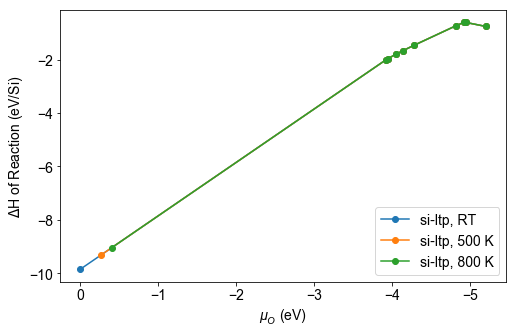

In [154]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/Si)')
ax.set_xlabel(r'$\mu_O$ (eV)')

norm_H1 = pnds.Series(si_LTP[2])
norm_H1 = norm_H1*2

norm_H2 = pnds.Series(si_LTP_200[2])
norm_H2 = norm_H2*2

norm_H3 = pnds.Series(si_LTP_500[2])
norm_H3 = norm_H3*2

p1 = plt.plot(si_LTP[0], norm_H1, 'o-', label= r'si-ltp, RT')
p2 = plt.plot(si_LTP_200[5], norm_H2, 'o-', label= r'si-ltp, 500 K')
p3 = plt.plot(si_LTP_500[5], norm_H3, 'o-', label= r'si-ltp, 800 K')

# plt.xlim(-3.25, 0.1)
# plt.ylim(-2.6, 0.5)
legend = ax.legend(loc='lower right')
ax.invert_xaxis()

plt.show()